In [31]:
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn import FunctionSampler
from collections import Counter

from joblib import Parallel, delayed


In [1]:
import pandas as pd
df = pd.read_csv("excel_files/baseline_features.csv",na_values=["#NULL!", "NULL", "N/A"], decimal=",")

df = df.apply(pd.to_numeric, errors="coerce")
df = df[df.isnull().sum(axis=1) <= 500]

In [2]:
targets = ['YSR_93_98_ad', 'YSR_93_98_wd',
       'YSR_93_98_sc', 'YSR_93_98_sp', 'YSR_93_98_tp', 'YSR_93_98_ap',
       'YSR_93_98_rb', 'YSR_93_98_ab', 'YSR_93_98_ip', 'YSR_93_98_ep',
       'YSR_93_98_ts']

In [3]:
# Step 1: Automatically find matching YSR_93_XX and YSR_98_XX pairs
suffixes = []
for col in df.columns:
    if col.startswith("YSR_93_"):
        suffix = col.replace("YSR_93_", "")
        if f"YSR_98_{suffix}" in df.columns:
            suffixes.append(suffix)

# Step 2: Create combined columns
combined_cols = {}
for suffix in suffixes:
    col_93 = f'YSR_93_{suffix}'
    col_98 = f'YSR_98_{suffix}'
    new_col = f'YSR_93_98_{suffix}'
    
    combined_cols[new_col] = ((df[col_93] == 1) | (df[col_98] == 1)).astype(int)

# Step 3: Insert new columns after the first 60 columns
# Split df into two parts: first 60 and the rest
first_part = df.iloc[:, :60].copy()
second_part = df.iloc[:, 60:].copy()

# Add new combined columns to first_part
for col_name, col_data in combined_cols.items():
    first_part[col_name] = col_data.values

# Concatenate first_part (now including new columns) and second_part
df = pd.concat([first_part, second_part], axis=1)

###code to eliminate the doubles acoustic features which I dont know where they came from

cols_to_check = df.columns[77:]
cols_to_keep = [col for col in cols_to_check if col.startswith("baseline_")]
df = df[df.columns[:77].tolist() + cols_to_keep]

In [4]:
# Identify all new combined columns (those starting with 'YSR_93_98_')
combined_cols = [col for col in df.columns if col.startswith('YSR_93_98_')]

# Create a summary DataFrame
summary = pd.DataFrame({
    'num_1s': df[combined_cols].sum(),
    'total_non_null': df[combined_cols].notnull().sum()
})

# Add a proportion column (optional)
summary['proportion_1s'] = summary['num_1s'] / summary['total_non_null']

# Sort by number of 1s descending (optional)
summary = summary.sort_values(by='num_1s', ascending=False)

# Show the summary
import ace_tools_open as tools; tools.display_dataframe_to_user(name="YSR Combined Column Summary", dataframe=summary)


YSR Combined Column Summary


In [9]:
df.columns[88:]

Index(['baseline_avgDF0', 'baseline_avgDDF0', 'baseline_avgJitter',
       'baseline_avgShimmer', 'baseline_avgapq', 'baseline_avgppq',
       'baseline_avglogE', 'baseline_stdDF0', 'baseline_stdDDF0',
       'baseline_stdJitter',
       ...
       'baseline_paa_deltachroma_12_min', 'baseline_paa_deltachroma_12_max',
       'baseline_paa_deltachroma_12_skew',
       'baseline_paa_deltachroma_12_kurtosis',
       'baseline_paa_deltachroma_std_mean', 'baseline_paa_deltachroma_std_std',
       'baseline_paa_deltachroma_std_min', 'baseline_paa_deltachroma_std_max',
       'baseline_paa_deltachroma_std_skew',
       'baseline_paa_deltachroma_std_kurtosis'],
      dtype='object', length=1027)

In [6]:
targets=['YSR_sad', 'YSR_swd', 'YSR_ssc', 'YSR_ssp', 'YSR_stp', 'YSR_sap',
       'YSR_srb', 'YSR_sab', 'YSR_sip', 'YSR_sep', 'YSR_sts']

insert_position = 77
for target in targets:
    median_value = df[target].median()
    binary_label = (df[target] > median_value).astype(int)
    df.insert(loc=insert_position, column=f"{target}_binary", value=binary_label)
    insert_position += 1  # Shift for the next insert

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, balanced_accuracy_score, confusion_matrix,
    precision_recall_curve
)
from xgboost import XGBClassifier
from tqdm import tqdm

target_columns = ['YSR_93_98_ad', 'YSR_93_98_wd',
       'YSR_93_98_sc', 'YSR_93_98_sp', 'YSR_93_98_tp', 'YSR_93_98_ap',
       'YSR_93_98_rb', 'YSR_93_98_ab', 'YSR_93_98_ip', 'YSR_93_98_ep',
       'YSR_93_98_ts', 'YSR_sad_binary', 'YSR_swd_binary',
       'YSR_ssc_binary', 'YSR_ssp_binary', 'YSR_stp_binary', 'YSR_sap_binary',
       'YSR_srb_binary', 'YSR_sab_binary', 'YSR_sip_binary', 'YSR_sep_binary',
       'YSR_sts_binary']
# Define acoustic feature columns
feature_cols = df.columns[88:]

results = []

# Range of k values to test
k_values = [10, 25, 50, 75, 100]

for target in tqdm(target_columns):
    data = df[[target] + list(feature_cols)].dropna()
    y = data[target]
    X = data[feature_cols]

    # Train/test split
    X_train_full, X_test, y_train_full, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Preprocess: scale
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_test_scaled = scaler.transform(X_test)

    # Cross-validation to select best k
    best_k = None
    best_f1 = -np.inf

    for k in k_values:
        f1s = []
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        for train_idx, val_idx in skf.split(X_train_scaled, y_train_full):
            X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
            y_tr, y_val = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

            selector = SelectKBest(mutual_info_classif, k=k)
            X_tr_sel = selector.fit_transform(X_tr, y_tr)
            X_val_sel = selector.transform(X_val)

            neg, pos = np.bincount(y_tr)
            scale = neg / pos

            model = XGBClassifier(
                scale_pos_weight=scale,
                use_label_encoder=False,
                eval_metric='aucpr',
                tree_method='gpu_hist',
                n_estimators=300,
                max_depth=6,
                learning_rate=0.05,
                random_state=42
            )
            model.fit(X_tr_sel, y_tr)
            y_val_pred = model.predict(X_val_sel)
            f1s.append(f1_score(y_val, y_val_pred, zero_division=0))

        avg_f1 = np.mean(f1s)
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_k = k

    # Retrain with best k on full training data
    selector = SelectKBest(mutual_info_classif, k=best_k)
    X_train_sel = selector.fit_transform(X_train_scaled, y_train_full)
    X_test_sel = selector.transform(X_test_scaled)

    # 🔧 Extract selected feature names
    selected_features = X.columns[selector.get_support()].tolist()

    neg, pos = np.bincount(y_train_full)
    ratio = neg / pos

    scale = ratio if ratio > 1.5 else 1  # Apply only for significant imbalance

    model = XGBClassifier(
        scale_pos_weight=scale,
        use_label_encoder=False,
        eval_metric='aucpr',
        tree_method='hist',
        device='cuda',
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        random_state=42
    )
    model.fit(X_train_sel, y_train_full)
    y_proba = model.predict_proba(X_test_sel)[:, 1]

    # 🔧 Get feature importances from model
    importances = model.feature_importances_
    feature_importance_dict = dict(zip(selected_features, importances))
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
    top5_features = sorted_importances[:5]

    top5_names = [f for f, _ in top5_features]
    top5_vals = [round(float(v), 4) for _, v in top5_features]
    top5_str = "; ".join([f"{name}: {val}" for name, val in zip(top5_names, top5_vals)])


    # Threshold tuning to achieve >=70% recall
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    idxs = np.where(recalls >= 0.7)[0]
    if len(idxs) > 0:
        precision_at_70recall = np.max(precisions[idxs])
    else:
        precision_at_70recall = np.nan

    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0. and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
    else:
        threshold = 0.5  # fallback

    y_pred = (y_proba >= threshold).astype(int)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    results.append({
        "Target": target,
        "Best_k": best_k,
        "F1": f1,
        "Balanced Accuracy": bal_acc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": acc,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp, "TN": tn, "FP": fp, "FN": fn,
        "Selected_Features": "; ".join(selected_features),
        "Top5_Important_Features": top5_str
    })


# Compile results
results_df = pd.DataFrame(results)
print(results_df)


  0%|          | 0/22 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [13:42:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [13:42:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


            Target  Best_k        F1  Balanced Accuracy  Precision    Recall  \
0     YSR_93_98_ad      25  0.238095           0.606902   0.161290  0.454545   
1     YSR_93_98_wd      75  0.232558           0.587446   0.136986  0.769231   
2     YSR_93_98_sc     100  0.288660           0.567107   0.177215  0.777778   
3     YSR_93_98_sp      10  0.148760           0.531818   0.080357  1.000000   
4     YSR_93_98_tp      25  0.232558           0.617601   0.135135  0.833333   
5     YSR_93_98_ap      25  0.322581           0.575758   0.192308  1.000000   
6     YSR_93_98_rb      10  0.127273           0.571429   0.067961  1.000000   
7     YSR_93_98_ab      10  0.105263           0.564035   0.060606  0.400000   
8     YSR_93_98_ip      50  0.408451           0.517041   0.258929  0.966667   
9     YSR_93_98_ep      10  0.333333           0.656863   0.205479  0.882353   
10    YSR_93_98_ts      10  0.396226           0.586642   0.262500  0.807692   
11  YSR_sad_binary      75  0.560510    

In [1]:
import pandas as pd

In [2]:
results_df=pd.read_csv("XGboost_T0_LATEX.csv")

In [3]:
results_df

Target;Best_k;F1;Balanced Accuracy;Precision;Recall;Accuracy;Precision@70%Recall;TP;TN;FP;FN
0   ab;10;0.10526315789473684;0.5640350877192983;0...                                          
1   ad;25;0.2777777777777778;0.6346801346801346;0....                                          
2   ap;100;0.39080459770114945;0.6724747474747474;...                                          
3   ep;50;0.2857142857142857;0.5833333333333334;0....                                          
4   ip;50;0.4142857142857143;0.5282771535580524;0....                                          
5   rb;10;0.12727272727272726;0.5714285714285714;0...                                          
6   sc;50;0.27692307692307694;0.5346534653465347;0...                                          
7   sp;10;0.17777777777777778;0.5767676767676768;0...                                          
8   tp;75;0.21978021978021978;0.5942367601246106;0...                                          
9   ts;100;0.4470588235294118;0.6503308519437552;0...                                          
10  wd;100;0.3157894736842105;0.6810595065312046;0...

In [12]:
results_df.to_csv("ALEXANDRA-XGBOOST-BASELINEEE.csv", index=False)

In [4]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Filter only binary targets
    binary_df = df[df["Target"].str.contains("_binary")].copy()

    # Extract short two-letter codes (e.g., T1_YSR_sab_binary → ab)
    short_labels = [t.split('_')[1][1:] for t in binary_df["Target"]]

    # Metric configurations
    metrics = [
        ("F1", "F1 Score", "dodgerblue", "Score"),
        ("Balanced Accuracy", "Balanced Accuracy", "tan", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "mediumseagreen", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = binary_df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].set_xticks(range(len(short_labels)))
    axes[-1].set_xticklabels(short_labels, fontsize=16, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()


In [5]:
plot_combined_metrics(results_df)

KeyError: 'Target'

In [ ]:
results_df.to_csv("XGBOOST_FEATURES_T0.csv", index=False)

In [93]:
########FOR 50505050055005


targets=['YSR_sad', 'YSR_swd', 'YSR_ssc', 'YSR_ssp', 'YSR_stp', 'YSR_sap',
       'YSR_srb', 'YSR_sab', 'YSR_sip', 'YSR_sep', 'YSR_sts']

insert_position = 77
for target in targets:
    median_value = df[target].median()
    binary_label = (df[target] > median_value).astype(int)
    df.insert(loc=insert_position, column=f"{target}_binary", value=binary_label)
    insert_position += 1  # Shift for the next insert

In [112]:
models_5050 = {
    "No FS": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "No FS - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "KBest": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KBest - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "PCA": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "PCA - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ])
}


In [96]:
targets_5050=['YSR_sad_binary', 'YSR_swd_binary',
       'YSR_ssc_binary', 'YSR_ssp_binary', 'YSR_stp_binary', 'YSR_sap_binary',
       'YSR_srb_binary', 'YSR_sab_binary', 'YSR_sip_binary', 'YSR_sep_binary',
       'YSR_sts_binary']

distribution = {}

for target in targets_5050:
    distribution[target] = df[target].value_counts().to_dict()

# Convert to DataFrame for better visualization
import pandas as pd
distribution_df = pd.DataFrame(distribution).T.fillna(0).astype(int)
distribution_df.columns = ['Count_0', 'Count_1'] if len(distribution_df.columns) == 2 else distribution_df.columns


In [97]:
distribution_df

Count_0  Count_1
YSR_sad_binary      431      276
YSR_swd_binary      391      316
YSR_ssc_binary      410      297
YSR_ssp_binary      370      337
YSR_stp_binary      403      304
YSR_sap_binary      384      323
YSR_srb_binary      407      300
YSR_sab_binary      376      331
YSR_sip_binary      397      310
YSR_sep_binary      399      308
YSR_sts_binary      376      331

In [82]:
distribution_df

Count_0  Count_1
YSR_93_98_ad_binary      637       70
YSR_93_98_wd_binary      628       79
YSR_93_98_sc_binary      603      104
YSR_93_98_sp_binary      645       62
YSR_93_98_tp_binary      633       74
YSR_93_98_ap_binary      586      121
YSR_93_98_rb_binary      659       48
YSR_93_98_ab_binary      677       30
YSR_93_98_ip_binary      532      175
YSR_93_98_ep_binary      609       98
YSR_93_98_ts_binary      551      156

In [28]:
targets_5050 = ['YSR_93_98_ad_binary', 'YSR_93_98_wd_binary',
       'YSR_93_98_sc_binary', 'YSR_93_98_sp_binary', 'YSR_93_98_tp_binary',
       'YSR_93_98_ap_binary', 'YSR_93_98_rb_binary', 'YSR_93_98_ab_binary',
       'YSR_93_98_ip_binary','YSR_93_98_ep_binary', 'YSR_93_98_ts_binary']

In [25]:
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)


In [29]:
def evaluate_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, min_precision, min_recall, recall_target):
    model_fold = clone(model)
    model_fold.fit(X_train_fold, y_train_fold)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba_val)
    f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= min_precision and r >= min_recall]

    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1s[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]
    else:
        threshold = 0.5

    y_pred_val = (y_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val_fold, y_pred_val, zero_division=0)
    precision = precision_score(y_val_fold, y_pred_val, zero_division=0)
    recall = recall_score(y_val_fold, y_pred_val, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    prec_at_70 = precision if recall >= recall_target else np.nan

    return f1, prec_at_70, threshold, bal_acc

# Updated cross_val_with_threshold_tuning with n_jobs
def cross_val_with_threshold_tuning(model, X, y, min_precision=0.3, min_recall=0.3, recall_target=0.7, n_splits=5, n_jobs=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_fold)(
            model,
            X.iloc[train_idx], y.iloc[train_idx],
            X.iloc[val_idx], y.iloc[val_idx],
            min_precision, min_recall, recall_target
        )
        for train_idx, val_idx in kf.split(X, y)
    )

    f1_scores, precisions_at_70recall, thresholds_used, bal_accs = zip(*results)

    return {
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Balanced Accuracy Mean": np.mean(bal_accs),
        "Balanced Accuracy Std": np.std(bal_accs),
        "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
        "Thresholds Used (Mean)": np.mean(thresholds_used)
    }

from imblearn.over_sampling import SMOTE

def safe_smote(X, y, random_state=42):
    # Count minority class samples
    from collections import Counter
    counter = Counter(y)
    min_class_count = min(counter.values())

    # Avoid errors by capping k_neighbors
    k = min(3, min_class_count - 1) if min_class_count > 1 else 1

    return SMOTE(k_neighbors=k, random_state=random_state).fit_resample(X, y)

In [32]:
results = []

var_thresh = VarianceThreshold(threshold=0.0)
scaler = RobustScaler()
kbest = SelectKBest(score_func=mutual_info_classif, k=100)
pca = PCA(n_components=50)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy'
}

models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', FunctionSampler(func=safe_smote, validate=False)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ])
    }

In [113]:
cv_results = []

for target in tqdm(targets_5050):
    data = df[[target]].join(df[df.columns[88:]]).dropna()
    y = data[target]
    X = data[df.columns[88:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models_5050.items():
        metrics = cross_val_with_threshold_tuning(
            model, X_train, y_train,  # <- important: use training set only
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        cv_results.append({
            "Target": target,
            "Model": model_name,
            "F1 Mean": metrics["F1 Mean"],
            "F1 Std": metrics["F1 Std"],
            "Balanced Accuracy Mean": metrics["Balanced Accuracy Mean"],
            "Balanced Accuracy Std": metrics["Balanced Accuracy Std"],
            "Precision@70%Recall Mean": metrics["Precision@70%Recall Mean"],
            "Thresholds Used (Mean)": metrics["Thresholds Used (Mean)"]
        })

# Final results per model and target
cv_df_5050 = pd.DataFrame(cv_results)
#cv_df_5050.to_csv("CV_BASELINE_all_models_5050.csv", index=False)
# Example: find best model per target
best_models_df_5050 = cv_df_5050.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()

  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

In [111]:
models_5050 = {
    "No FS": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "No FS - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "KBest": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "KBest - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('kbest', kbest),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ]),
    "PCA": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    "PCA - ElasticNet": Pipeline([
        ('var', var_thresh),
        ('scaler', scaler),
        ('pca', pca),
        ('logreg', LogisticRegressionCV(
            Cs=10,
            penalty='elasticnet',
            solver='saga',
            l1_ratios=[0.5],
            cv=5,
            scoring='average_precision',
            max_iter=2000,
            random_state=42
        ))
    ])
}


In [ ]:
cv_df = pd.read_csv("CV_baseline_all_models_CORRECT.csv")
best_models = cv_df.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()

In [114]:
final_results = []

for _, row in best_models_df_5050.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models_5050[model_name])

    # Prepare data
    data = df[[target]].join(df[df.columns[90:]]).dropna()
    y = data[target]
    X = data[df.columns[90:]]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit model
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Threshold tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= 0.3 and r >= 0.3]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5
        best_f1 = np.nan

    # Predict with threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

    # Precision at 70% recall
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= 0.7]
    precision_at_70recall = max([precisions[i] for i in valid_idxs_70]) if valid_idxs_70 else np.nan

    # Confusion matrix
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    # ---- Extract Top 3 Features (keep full names) ----
    if "PCA" not in model_name:
        try:
            coefs = model.named_steps["logreg"].coef_[0] if hasattr(model, "named_steps") else model.coef_[0]
            feature_names = X.columns
            sorted_indices = np.argsort(np.abs(coefs))[::-1][:3]
            top_features = [feature_names[i] for i in sorted_indices]
            top_coefs = [coefs[i] for i in sorted_indices]
        except Exception as e:
            print(f"⚠️ Feature extraction failed for {target}: {e}")
            top_features = [""] * 3
            top_coefs = [np.nan] * 3
    else:
        top_features = [""] * 3
        top_coefs = [np.nan] * 3

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec_at_thresh,
        "Recall": recall_at_thresh,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "Top Feature 1": top_features[0],
        "Top Feature 2": top_features[1],
        "Top Feature 3": top_features[2],
        "Coef 1": top_coefs[0],
        "Coef 2": top_coefs[1],
        "Coef 3": top_coefs[2],
    })

# Final dataframe
final_results_correctt0_THIS = pd.DataFrame(final_results)
#final_results_correctt0_THIS.to_csv("5050505050FINAL_TEST_with_features_BASELINE.csv", index=False)
final_results_correctt0_THIS.to_csv("THIS_YEAH_T0_5050.csv", index=False)

/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [115]:
final_results_correctt0_THIS

Target               Model  Accuracy  Precision    Recall  \
0   YSR_sab_binary  No FS - ElasticNet  0.495798   0.487179  1.000000   
1   YSR_sad_binary               No FS  0.579832   0.472973  0.760870   
2   YSR_sap_binary  KBest - ElasticNet  0.453782   0.453782  1.000000   
3   YSR_sep_binary  KBest - ElasticNet  0.504202   0.471698  0.943396   
4   YSR_sip_binary    PCA - ElasticNet  0.453782   0.444444  1.000000   
5   YSR_srb_binary    PCA - ElasticNet  0.470588   0.446429  0.980392   
6   YSR_ssc_binary  KBest - ElasticNet  0.613445   0.525641  0.820000   
7   YSR_ssp_binary                 PCA  0.478992   0.478992  1.000000   
8   YSR_stp_binary                 PCA  0.462185   0.443478  1.000000   
9   YSR_sts_binary  KBest - ElasticNet  0.504202   0.491379  1.000000   
10  YSR_swd_binary    PCA - ElasticNet  0.436975   0.436975  1.000000   

    F1 (test)  Balanced Accuracy (test)  Threshold Used  F1 at Threshold  \
0    0.655172                  0.516129    1.343428e-01         0.655172   
1    0.583333                  0.613311    1.566769e-02         0.583333   
2    0.624277                  0.500000    3.693237e-01         0.624277   
3    0.628931                  0.547456    3.208872e-01         0.628931   
4    0.615385                  0.514925    3.374223e-01         0.615385   
5    0.613497                  0.534314    2.626912e-01         0.613497   
6    0.640625                  0.641884    3.435824e-01         0.640625   
7    0.647727                  0.500000    1.793092e-12         0.647727   
8    0.614458                  0.529412    1.177274e-01         0.614458   
9    0.658960                  0.524194    3.029005e-01         0.658960   
10   0.608187                  0.500000    9.236259e-02         0.608187   

    Precision@70%Recall  TP  TN  FP  FN                        Top Feature 1  \
0              0.505747  57   2  60   0  baseline_paa_deltachroma_3_kurtosis   
1              0.478261  35  34  39  11         baseline_paa_deltamfcc_5_max   
2              0.459459  54   0  65   0                     baseline_stdDDF0   
3              0.500000  50  10  56   3                  baseline_avgBBEon_9   
4              0.444444  52   2  65   0                                        
5              0.446429  50   6  62   1                                        
6              0.534247  41  32  37   9                baseline_avgBBEoff_12   
7              0.505882  57   0  62   0                                        
8              0.444444  51   4  64   0                                        
9              0.525641  57   3  59   0                baseline_avgBBEoff_14   
10             0.481928  52   0  67   0                                        

                     Top Feature 2                      Top Feature 3  \
0   baseline_paa_deltachroma_9_max                   baseline_avgDDF2   
1   baseline_paa_deltachroma_8_max  baseline_paa_deltamfcc_9_kurtosis   
2           baseline_avgDDMFCCon_5              baseline_avgBBEoff_16   
3            baseline_avgMFCCon_12               baseline_avgMFCCon_6   
4                                                                       
5                                                                       
6                  baseline_avgppq             baseline_avgDDMFCCon_5   
7                                                                       
8                                                                       
9             baseline_avgBBEoff_2               baseline_avgBBEon_19   
10                                                                      

      Coef 1    Coef 2    Coef 3  
0  -0.064207  0.052765 -0.051520  
1   0.742150  0.728353  0.665537  
2  -0.005969 -0.001237  0.000000  
3  -0.149814  0.119711 -0.098097  
4        NaN       NaN       NaN  
5        NaN       NaN       NaN  
6  -0.188553 -0.167963  0.165065  
7        NaN       NaN       NaN  
8        NaN       NaN       NaN  
9   0.122744 -0.088336  0.087827  

In [11]:
test = pd.read_csv("XGboost_T0_LATEX.csv")

In [12]:
test

Target  Best_k        F1  Balanced Accuracy  Precision    Recall  Accuracy  \
0      ab      10  0.105263           0.564035   0.060606  0.400000  0.714286   
1      ad      25  0.277778           0.634680   0.200000  0.454545  0.781513   
2      ap     100  0.390805           0.672475   0.253731  0.850000  0.554622   
3      ep      50  0.285714           0.583333   0.166667  1.000000  0.285714   
4      ip      50  0.414286           0.528277   0.263636  0.966667  0.310924   
5      rb      10  0.127273           0.571429   0.067961  1.000000  0.193277   
6      sc      50  0.276923           0.534653   0.160714  1.000000  0.210084   
7      sp      10  0.177778           0.576768   0.111111  0.444444  0.689076   
8      tp      75  0.219780           0.594237   0.126582  0.833333  0.403361   
9      ts     100  0.447059           0.650331   0.322034  0.730769  0.605042   
10     wd     100  0.315789           0.681060   0.204545  0.692308  0.672269   

    Precision@70%Recall  TP  TN  FP  FN  
0              0.043860   2  83  31   3  
1              0.105882   5  88  20   6  
2              0.253731  17  49  50   3  
3              0.168675  17  17  85   0  
4              0.280488  29   8  81   1  
5              0.068182   7  16  96   0  
6              0.160714  18   7  94   0  
7              0.077586   4  78  32   5  
8              0.126582  10  38  69   2  
9              0.322034  19  53  40   7  
10             0.142857   9  71  35   4

In [29]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]
    short_labels = [label.split('_')[1][1:] for label in target_order]

    # Metric configurations
    metrics = [
        ("F1 (test)", "F1 Score", "steelblue", "Score"),
        ("Balanced Accuracy (test)", "Balanced Accuracy", "sandybrown", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "seagreen", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        #ax.set_ylabel(ylabel, fontsize=14)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=11)

    # Make x-axis labels bold
    axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()

In [25]:
test1= pd.read_csv("ALEXANDRA_XGBOOSTFEATURES_T1.csv")

In [30]:
test1

Target  Best_k        F1  Balanced Accuracy  Precision  \
0     T1_YSR_93_98_ad      75  0.428571           0.640741   0.750000   
1     T1_YSR_93_98_wd     100  0.418605           0.617347   0.310345   
2     T1_YSR_93_98_sc      75  0.300000           0.593939   0.272727   
3     T1_YSR_93_98_sp      10  0.215385           0.552632   0.120690   
4     T1_YSR_93_98_tp      75  0.461538           0.669318   0.600000   
5     T1_YSR_93_98_ap      10  0.470588           0.654422   0.421053   
6     T1_YSR_93_98_rb      10  0.285714           0.687500   0.166667   
7     T1_YSR_93_98_ab      10  0.085106           0.647541   0.044444   
8     T1_YSR_93_98_ip     100  0.517647           0.500000   0.349206   
9     T1_YSR_93_98_ep      25  0.400000           0.638889   0.500000   
10    T1_YSR_93_98_ts      10  0.450704           0.557545   0.296296   
11  T1_YSR_sad_binary      50  0.682927           0.613725   0.538462   
12  T1_YSR_swd_binary     100  0.652632           0.500000   0.484375   
13  T1_YSR_ssc_binary      25  0.666667           0.721660   0.680000   
14  T1_YSR_ssp_binary      50  0.647887           0.665128   0.500000   
15  T1_YSR_stp_binary      25  0.636364           0.539901   0.474576   
16  T1_YSR_sap_binary      75  0.688172           0.546875   0.524590   
17  T1_YSR_srb_binary      50  0.652632           0.500000   0.484375   
18  T1_YSR_sab_binary     100  0.577778           0.500000   0.406250   
19  T1_YSR_sip_binary     100  0.655738           0.673399   0.625000   
20  T1_YSR_sep_binary      25  0.645161           0.514706   0.476190   
21  T1_YSR_sts_binary     100  0.659574           0.515152   0.492063   

      Recall  Accuracy  Precision@70%Recall  TP  TN  FP  FN  \
0   0.300000  0.875000             0.266667   3  53   1   7   
1   0.642857  0.603175             0.285714   9  29  20   5   
2   0.333333  0.781250             0.163636   3  47   8   6   
3   1.000000  0.203125             0.120690   7   6  51   0   
4   0.375000  0.888889             0.162162   3  53   2   5   
5   0.533333  0.718750             0.276596   8  38  11   7   
6   1.000000  0.444444             0.166667   7  21  35   0   
7   1.000000  0.317460             0.044444   2  18  43   0   
8   1.000000  0.349206             0.365385  22   0  41   0   
9   0.333333  0.857143             0.269231   3  51   3   6   
10  0.941176  0.380952             0.296296  16   8  38   1   
11  0.933333  0.593750             0.540000  28  10  24   2   
12  1.000000  0.484375             0.500000  31   0  33   0   
13  0.653846  0.734375             0.500000  17  30   8   9   
14  0.920000  0.609375             0.500000  23  16  23   2   
15  0.965517  0.500000             0.538462  28   4  31   1   
16  1.000000  0.546875             0.524590  32   3  29   0   
17  1.000000  0.484375             0.490566  31   0  33   0   
18  1.000000  0.406250             0.407407  26   0  38   0   
19  0.689655  0.671875             0.512195  20  23  12   9   
20  1.000000  0.484375             0.500000  30   1  33   0   
21  1.000000  0.500000             0.509434  31   1  32   0   

                                    Selected_Features  \
0   t1_avgJitter; t1_stdlogE; t1_skewnessDF0; t1_s...   
1   t1_avgDF0; t1_kurtosisDDF0; t1_kurtosisapq; t1...   
2   t1_avgJitter; t1_stdJitter; t1_kurtosisppq; t1...   
3   t1_stdapq; t1_avgDMFCCoff_8; t1_stdBBEon_22; t...   
4   t1_avgDDF0; t1_kurtosislogE; t1_avgBBEon_18; t...   
5   t1_avgJitter; t1_avgBBEon_18; t1_F0tiltstd; t1...   
6   t1_avgMFCCoff_8; t1_stdDMFCCoff_7; t1_skewness...   
7   t1_stdDF2; t1_kurtosisBBEon_4; t1_kurtosisBBEo...   
8   t1_avgJitter; t1_skewnessJitter; t1_skewnessSh...   
9   t1_avgMFCCon_2; t1_avgMFCCon_6; t1_avgMFCCoff_...   
10  t1_skewnessBBEoff_8; t1_skewnessBBEoff_14; t1_...   
11  t1_stdDF0; t1_avgMFCCon_1; t1_avgDDMFCCon_2; t...   
12  t1_stdppq; t1_avgBBEon_8; t1_avgDMFCCon_3; t1_...   
13  t1_avgDDMFCCon_8; t1_stdBBEon_9; t1_stdBBEon_1...   
14  t1_stdlogE; t1_avgBBEon_11

KeyError: 'F1 (test)'

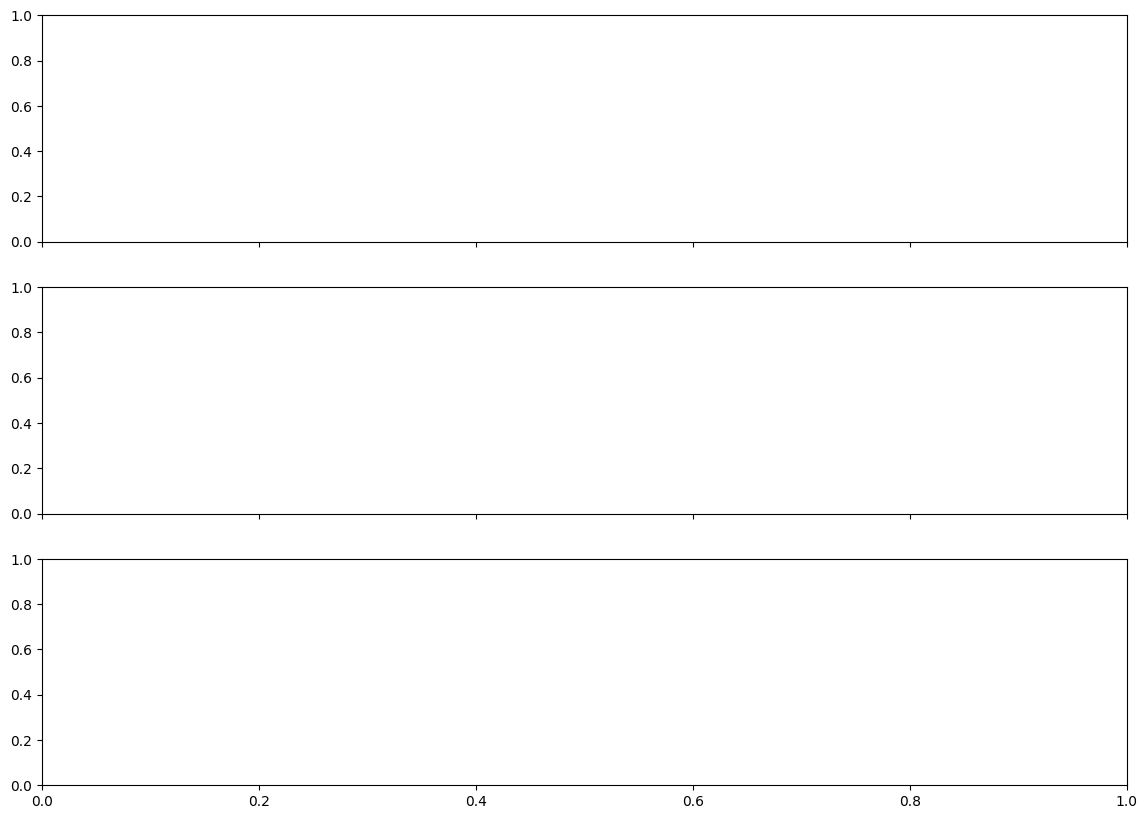

In [31]:
plot_combined_metrics(test1)

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

def plot_top_features_boxplots(df, final_results_df, target):
    # Get top 3 features for the specified target
    row = final_results_df[final_results_df["Target"] == target]
    if row.empty:
        print(f"⚠️ Target {target} not found in results.")
        return

    top_feats = [row["Top Feature 1"].values[0],
                 row["Top Feature 2"].values[0],
                 row["Top Feature 3"].values[0]]

    if target not in df.columns:
        print(f"⚠️ Target {target} not in main DataFrame.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    sns.set(style="whitegrid")

    for i, feat in enumerate(top_feats):
        ax = axes[i]
        if not feat or feat not in df.columns:
            ax.set_visible(False)
            continue

        # Remove extreme outliers using IQR
        Q1 = df[feat].quantile(0.25)
        Q3 = df[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        clean_df = df[(df[feat] >= lower_bound) & (df[feat] <= upper_bound)]

        # Mann–Whitney U test
        data = clean_df[[target, feat]].dropna()
        group_0 = data[data[target] == 0][feat]
        group_1 = data[data[target] == 1][feat]

        if len(group_0) >= 5 and len(group_1) >= 5:
            p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')[1]
            p_display = f"(p = {p_value:.3f})" + (" *" if p_value < 0.05 else "")
        else:
            p_display = "(p = NA)"

        title = f"{feat}\n{p_display}"

        # Plotting
        sns.boxplot(x=target, y=feat, hue=target, data=clean_df, ax=ax,
                    palette="Set2", width=0.5, fliersize=3, legend=False)
        sns.stripplot(x=target, y=feat, data=clean_df, ax=ax,
                      jitter=0.25, size=3, color="gray", alpha=0.4)

        ax.set_title(title, fontsize=18, fontweight='bold')
        ax.set_xlabel("")
        ax.set_ylabel("")

        ax.tick_params(axis='both', which='major', labelsize=18)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()


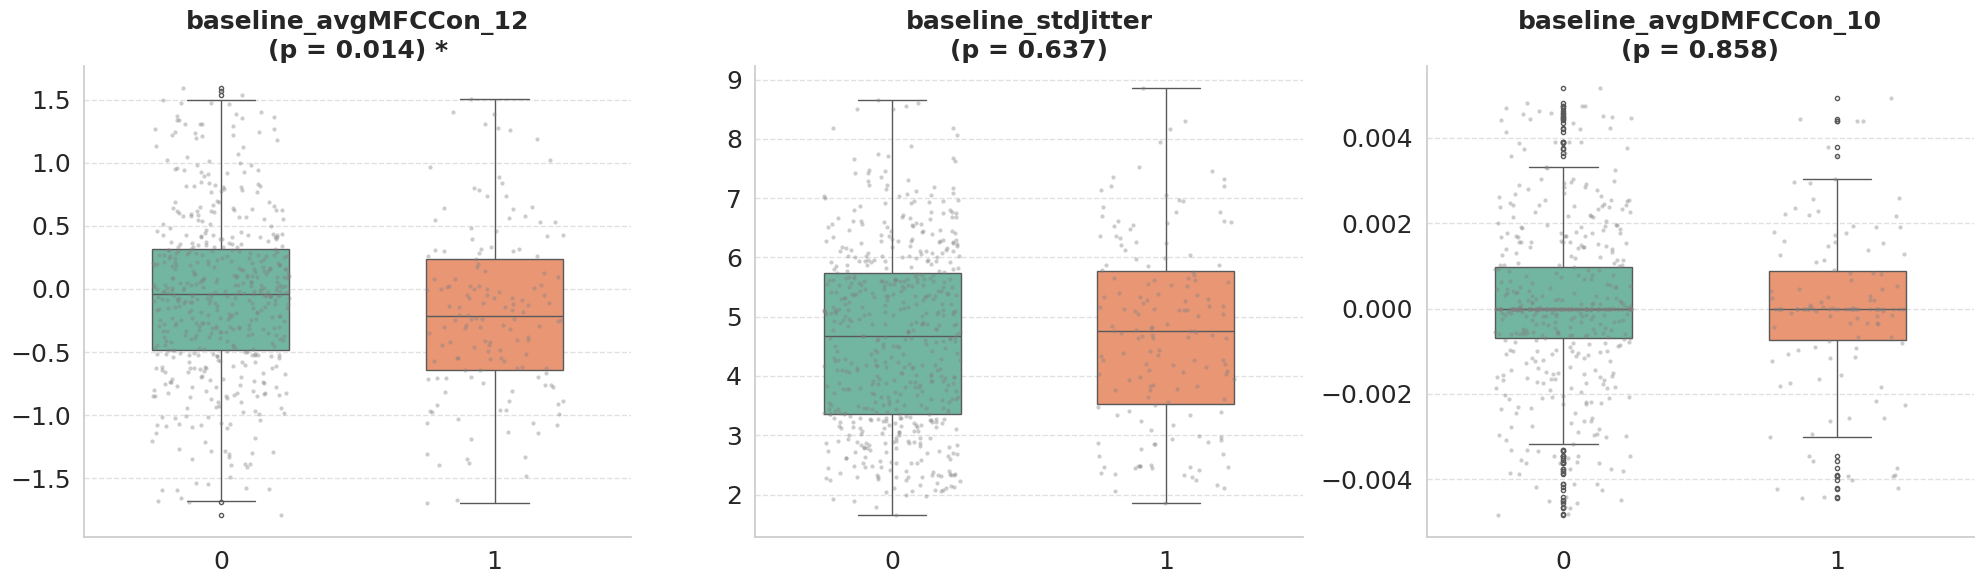

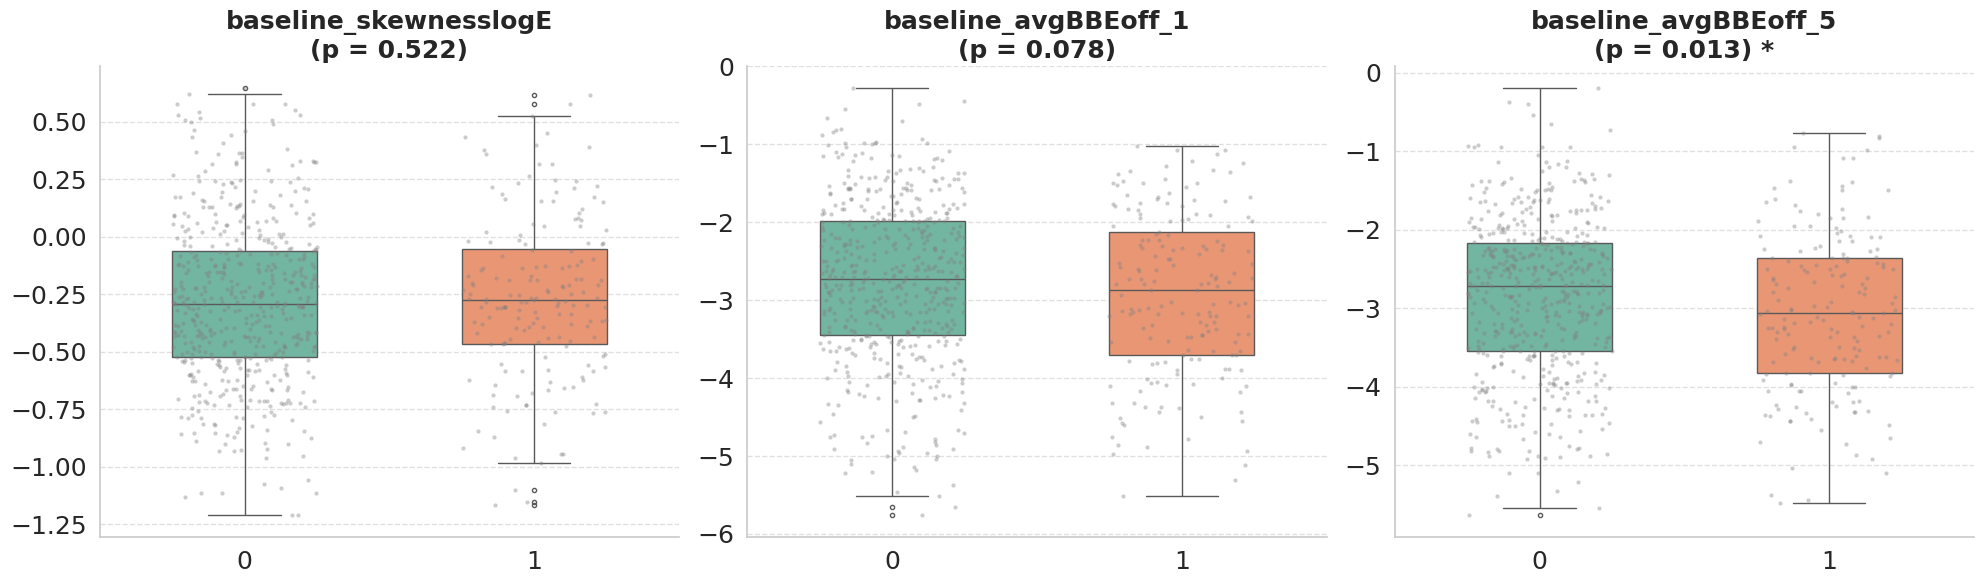

In [67]:
plot_top_features_boxplots(df, final_results_correctt0_THIS, target="YSR_93_98_ts")
plot_top_features_boxplots(df, final_results_correctt0_THIS, target="YSR_93_98_ip")

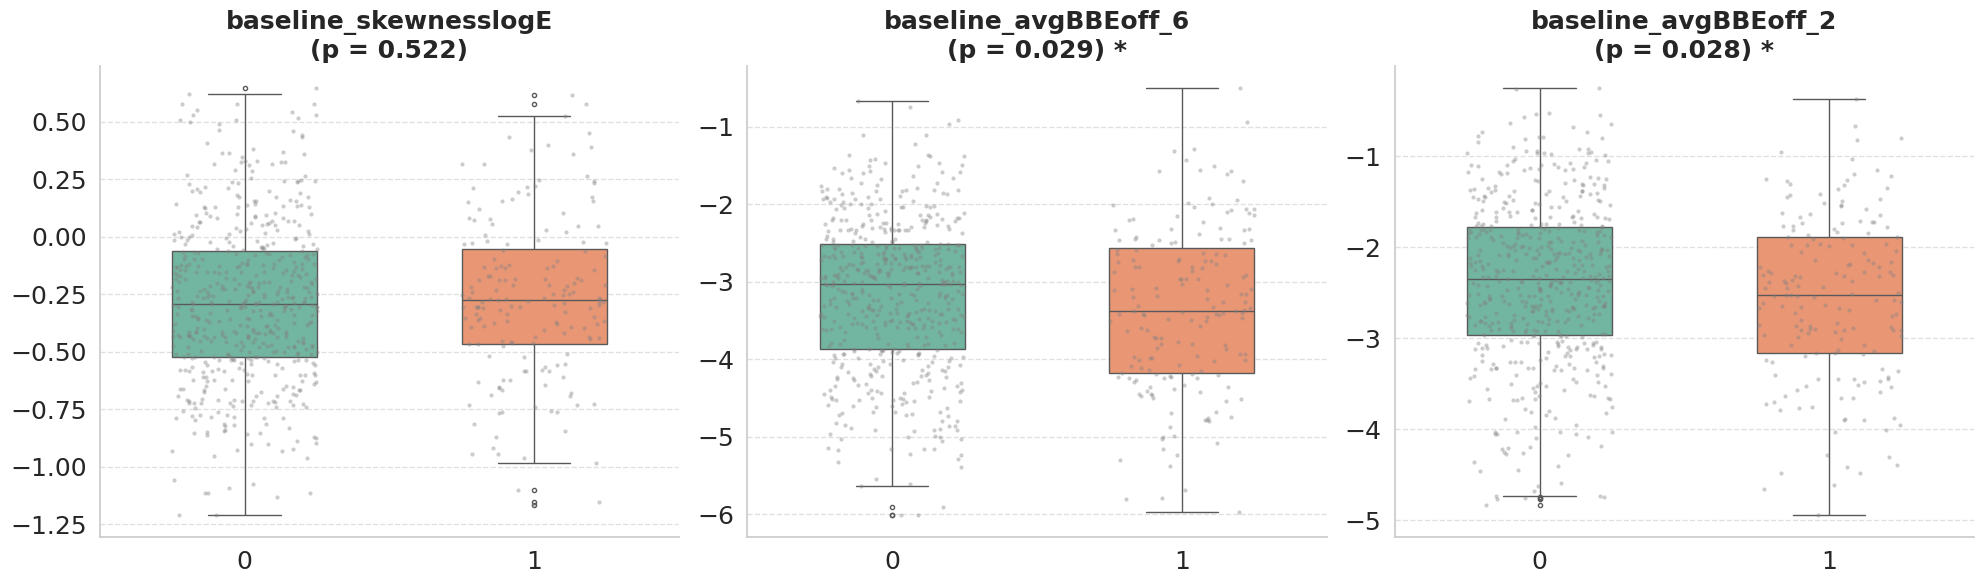

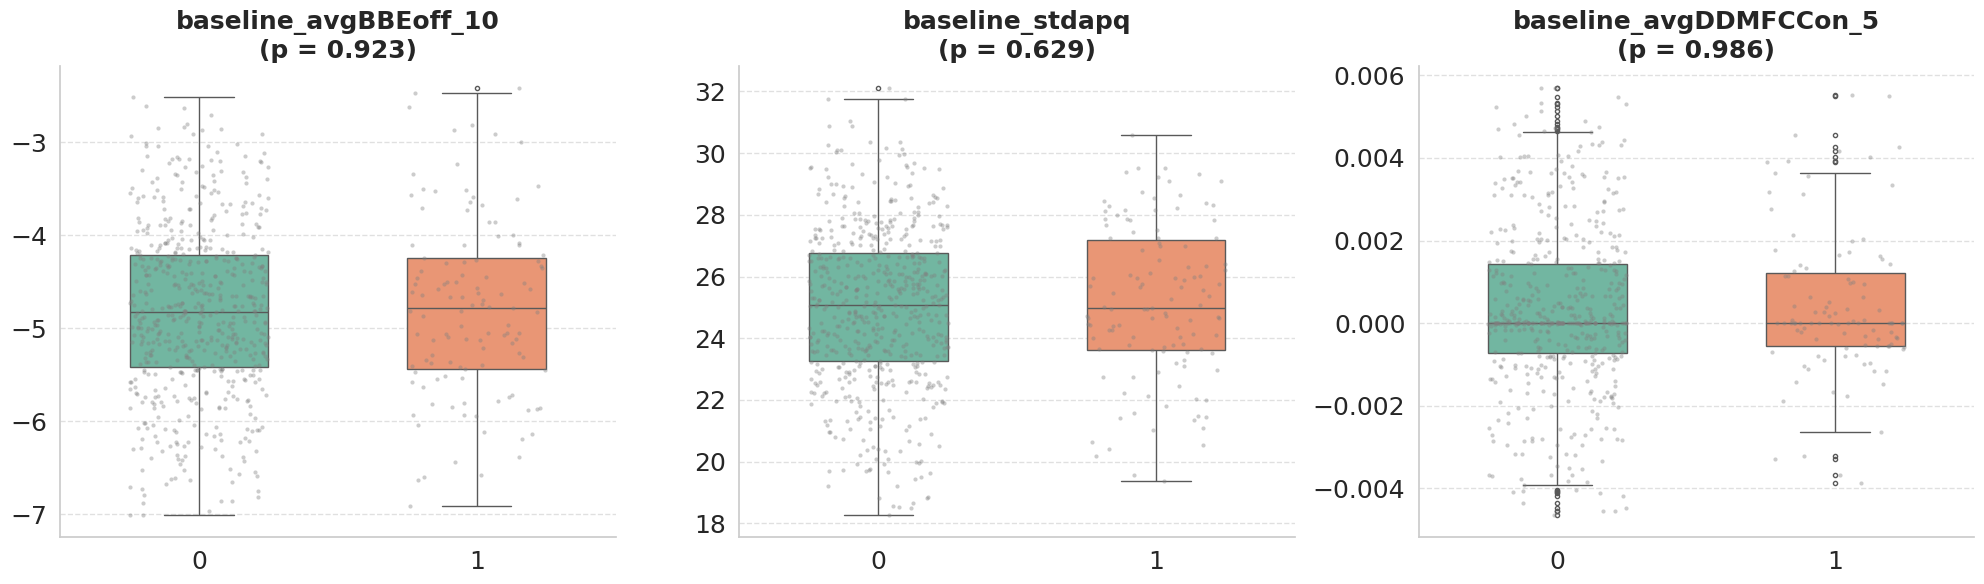

In [79]:
df_5050=pd.read_csv("FINAL_TEST_with_features_BASELINE_5050.csv")

plot_top_features_boxplots(df,df_5050 , target="YSR_93_98_ip_binary")
plot_top_features_boxplots(df, df_5050, target="YSR_93_98_ap_binary")

In [27]:
import matplotlib.pyplot as plt

def plot_combined_metrics(df, ylim=(0, 0.8)):
    # Use the order in which targets appear in the DataFrame
    target_order = df["Target"]
    short_labels = [label.split('_')[3] for label in target_order]

    # Metric configurations
    metrics = [
        ("F1 (test)", "F1 Score", "steelblue", "Score"),
        ("Balanced Accuracy (test)", "Balanced Accuracy", "sandybrown", "Score"),
        ("Precision@70%Recall", "Precision at 70% Recall", "seagreen", "Precision")
    ]

    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)

    for ax, (col, title, color, ylabel) in zip(axes, metrics):
        values = df[col].values
        bars = ax.bar(short_labels, values, color=color)
        ax.set_title(title, fontsize=20, pad=10)
        #ax.set_ylabel(ylabel, fontsize=14)
        ax.set_ylim(*ylim)
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        ax.tick_params(axis='y', labelsize=15)

    # Format x-axis for the bottom plot
    axes[-1].set_xlabel("Target Variable", fontsize=14)
    axes[-1].tick_params(axis='x', labelsize=11)

    # Make x-axis labels bold
    axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')

    plt.tight_layout(h_pad=2)
    plt.show()

KeyError: 'F1 (test)'

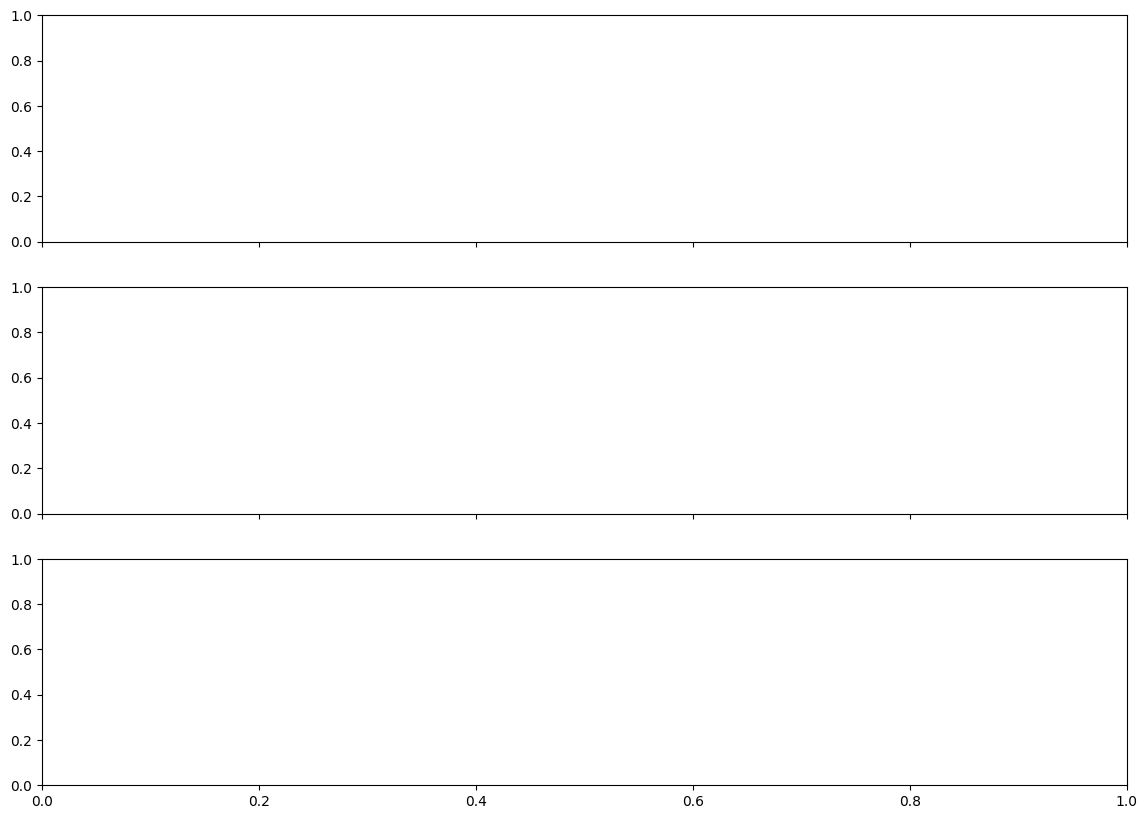

In [28]:
plot_combined_metrics(test1)


/tmp/ipykernel_3179194/194715352.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[-1].set_xticklabels(short_labels, fontsize=20, fontweight='bold')


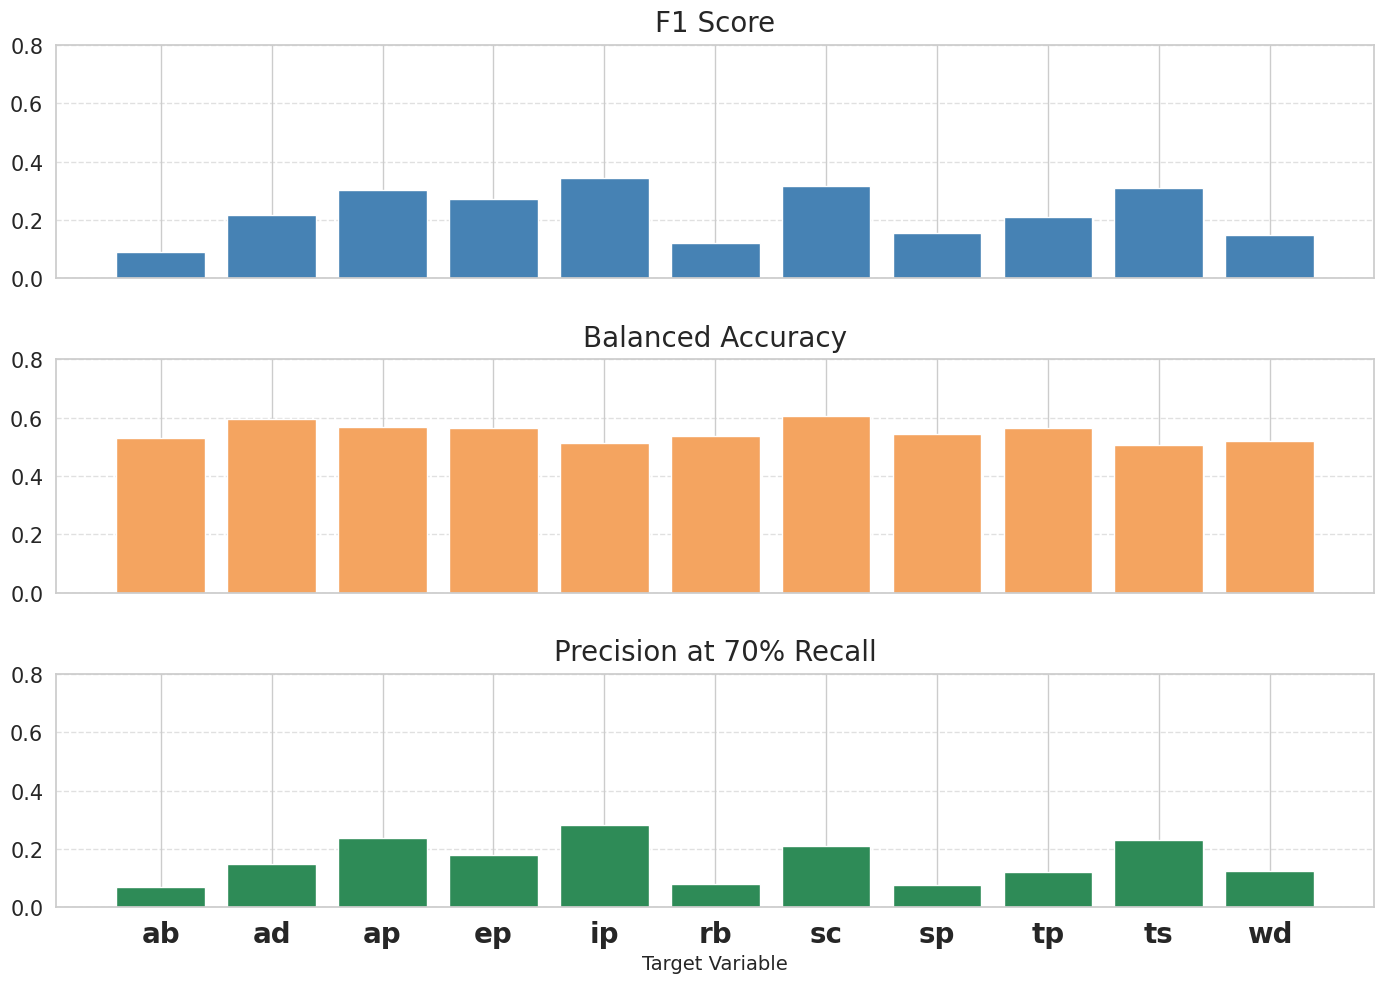

In [71]:
the_df = pd.read_csv("FINAL_TEST_with_features_BASELINE_5050.csv")

plot_combined_metrics(the_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_top_features_boxplots(df, final_results_df, target):
    # Get top 3 features for the specified target
    row = final_results_df[final_results_df["Target"] == target]
    if row.empty:
        print(f"⚠️ Target {target} not found in results.")
        return

    top_feats = [row["Top Feature 1"].values[0],
                 row["Top Feature 2"].values[0],
                 row["Top Feature 3"].values[0]]

    # Filter original dataframe to valid rows
    if target not in df.columns:
        print(f"⚠️ Target {target} not in main DataFrame.")
        return

    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    sns.set(style="whitegrid")

    for i, feat in enumerate(top_feats):
        ax = axes[i]
        if not feat or feat not in df.columns:
            ax.set_visible(False)
            continue

        # Remove extreme outliers robustly
        q_low, q_high = df[feat].quantile([0.1, 0.95])
        clean_df = df[(df[feat] >= q_low) & (df[feat] <= q_high)]

        if clean_df[feat].max() > 1e6:
            clean_df = clean_df[clean_df[feat] < 1e6]

        sns.boxplot(x=target, y=feat, hue=target, data=clean_df, ax=ax, palette="Set2", width=0.5, fliersize=3, legend=False)
        sns.stripplot(x=target, y=feat, data=clean_df, ax=ax, jitter=0.25, size=3, color="gray", alpha=0.4)

        ax.set_title(feat, fontsize=11, pad=10)
        ax.set_xlabel("Label (0 = Normal, 1 = Clinical)", fontsize=10)
        ax.set_ylabel("Feature Value", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.6)
        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

In [6]:
target_columns = ['YSR_93_98_ad', 'YSR_93_98_wd',
       'YSR_93_98_sc', 'YSR_93_98_sp', 'YSR_93_98_tp', 'YSR_93_98_ap',
       'YSR_93_98_rb', 'YSR_93_98_ab', 'YSR_93_98_ip', 'YSR_93_98_ep',
       'YSR_93_98_ts']

var_thresh = VarianceThreshold(threshold=0.0)
scaler = RobustScaler()
kbest = SelectKBest(score_func=mutual_info_classif, k=100)
pca = PCA(n_components=50)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy'
}

models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ])
    }

In [7]:
# Re-import necessary libraries after reset
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_recall_curve, f1_score, precision_score,
    recall_score, balanced_accuracy_score
)
from sklearn.base import clone

from joblib import Parallel, delayed

def evaluate_fold(model, X_train_fold, y_train_fold, X_val_fold, y_val_fold, min_precision, min_recall, recall_target):
    model_fold = clone(model)
    model_fold.fit(X_train_fold, y_train_fold)
    y_proba_val = model_fold.predict_proba(X_val_fold)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val_fold, y_proba_val)
    f1s = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1])) if p >= min_precision and r >= min_recall]

    if valid_idxs:
        best_idx = valid_idxs[np.argmax([f1s[i] for i in valid_idxs])]
        threshold = thresholds[best_idx]
    else:
        threshold = 0.5

    y_pred_val = (y_proba_val >= threshold).astype(int)
    f1 = f1_score(y_val_fold, y_pred_val, zero_division=0)
    precision = precision_score(y_val_fold, y_pred_val, zero_division=0)
    recall = recall_score(y_val_fold, y_pred_val, zero_division=0)
    bal_acc = balanced_accuracy_score(y_val_fold, y_pred_val)
    prec_at_70 = precision if recall >= recall_target else np.nan

    return f1, prec_at_70, threshold, bal_acc

# Updated cross_val_with_threshold_tuning with n_jobs
def cross_val_with_threshold_tuning(model, X, y, min_precision=0.3, min_recall=0.3, recall_target=0.7, n_splits=5, n_jobs=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_fold)(
            model,
            X.iloc[train_idx], y.iloc[train_idx],
            X.iloc[val_idx], y.iloc[val_idx],
            min_precision, min_recall, recall_target
        )
        for train_idx, val_idx in kf.split(X, y)
    )

    f1_scores, precisions_at_70recall, thresholds_used, bal_accs = zip(*results)

    return {
        "F1 Mean": np.mean(f1_scores),
        "F1 Std": np.std(f1_scores),
        "Balanced Accuracy Mean": np.mean(bal_accs),
        "Balanced Accuracy Std": np.std(bal_accs),
        "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
        "Thresholds Used (Mean)": np.mean(thresholds_used)
    }

In [8]:
cv_results = []

for target in tqdm(target_columns):
    data = df[[target]].join(df[df.columns[77:]]).dropna()
    y = data[target]
    X = data[df.columns[77:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models.items():
        metrics = cross_val_with_threshold_tuning(
            model, X_train, y_train,  # <- important: use training set only
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        cv_results.append({
            "Target": target,
            "Model": model_name,
            "F1 Mean": metrics["F1 Mean"],
            "F1 Std": metrics["F1 Std"],
            "Balanced Accuracy Mean": metrics["Balanced Accuracy Mean"],
            "Balanced Accuracy Std": metrics["Balanced Accuracy Std"],
            "Precision@70%Recall Mean": metrics["Precision@70%Recall Mean"],
            "Thresholds Used (Mean)": metrics["Thresholds Used (Mean)"]
        })

# Final results per model and target
cv_df = pd.DataFrame(cv_results)
cv_df.to_csv("CV_baseline_all_models_CORRECT.csv", index=False)
# Example: find best model per target
best_models_df = cv_df.sort_values(['Target', 'F1 Mean'], ascending=[True, False]).groupby('Target').first().reset_index()


  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_3179194/3641291259.py:58: RuntimeWarning: Mean of empty slice
  "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
/tmp/ipykernel_3179194/3641291259.py:58: RuntimeWarning: Mean of empty slice
  "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-pack

In [12]:
final_results = []

for _, row in best_models_df.iterrows():
    target = row["Target"]
    model_name = row["Model"]
    model = clone(models[model_name])

    # Prepare data
    data = df[[target]].join(df[df.columns[77:]]).dropna()
    y = data[target]
    X = data[df.columns[77:]]

    # Train/test split (held-out test set)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Fit on train set
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    # ----- Precision-Recall Curve & Threshold Tuning -----
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
    f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]
    valid_idxs = [
        i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1]))
        if p >= 0.3 and r >= 0.3
    ]

    if valid_idxs:
        best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
        threshold = thresholds[best_f1_idx]
        best_f1 = f1_scores[best_f1_idx]
    else:
        threshold = 0.5  # fallback
        best_f1 = np.nan

    # Final prediction using selected threshold
    y_pred = (y_proba >= threshold).astype(int)
    prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
    recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)
    # Compute precision@70% recall from the full PR curve
    recall_target = 0.7
    valid_idxs_70 = [i for i, r in enumerate(recalls[:-1]) if r >= recall_target]
    if valid_idxs_70:
        precision_at_70recall = max([precisions[i] for i in valid_idxs_70])
    else:
        precision_at_70recall = np.nan


    # Confusion matrix and metrics
    acc = accuracy_score(y_test, y_pred)
    precision = prec_at_thresh
    recall = recall_at_thresh
    f1 = f1_score(y_test, y_pred, zero_division=0)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    final_results.append({
        "Target": target,
        "Model": model_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 (test)": f1,
        "Balanced Accuracy (test)": bal_acc,
        "Threshold Used": threshold,
        "F1 at Threshold": best_f1,
        "Precision@70%Recall": precision_at_70recall,
        "TP": tp,
        "TN": tn,
        "FP": fp,
        "FN": fn
    })

# Convert to DataFrame
final_results_df = pd.DataFrame(final_results)
final_results_df.to_csv("TEST_baseline_all_models_CORRECT.csv", index=False)

/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [13]:
final_results_df

Target               Model  Accuracy  Precision    Recall  \
0   YSR_93_98_ab      PCA - Balanced  0.831933   0.058824  0.200000   
1   YSR_93_98_ad    PCA - ElasticNet  0.638655   0.136364  0.545455   
2   YSR_93_98_ap       No FS - SMOTE  0.672269   0.148148  0.200000   
3   YSR_93_98_ep    PCA - ElasticNet  0.470588   0.171429  0.705882   
4   YSR_93_98_ip  KBest - ElasticNet  0.478992   0.250000  0.533333   
5   YSR_93_98_rb       KBest - SMOTE  0.840336   0.125000  0.285714   
6   YSR_93_98_sc    PCA - ElasticNet  0.487395   0.197183  0.777778   
7   YSR_93_98_sp         PCA - SMOTE  0.731092   0.103448  0.333333   
8   YSR_93_98_tp  No FS - ElasticNet  0.747899   0.153846  0.333333   
9   YSR_93_98_ts       KBest - SMOTE  0.613445   0.261905  0.423077   
10  YSR_93_98_wd    No FS - Balanced  0.806723   0.142857  0.153846   

    F1 (test)  Balanced Accuracy (test)  Threshold Used  F1 at Threshold  \
0    0.090909                  0.529825             0.5              NaN   
1    0.218182                  0.596801             0.5              NaN   
2    0.170213                  0.483838             0.5              NaN   
3    0.275862                  0.568627             0.5              NaN   
4    0.340426                  0.497004             0.5              NaN   
5    0.173913                  0.580357             0.5              NaN   
6    0.314607                  0.606711             0.5              NaN   
7    0.157895                  0.548485             0.5              NaN   
8    0.210526                  0.563863             0.5              NaN   
9    0.323529                  0.544872             0.5              NaN   
10   0.148148                  0.520319             0.5              NaN   

    Precision@70%Recall  TP  TN  FP  FN  
0              0.049383   1  98  16   4  
1              0.153846   6  70  38   5  
2              0.227848   4  76  23  16  
3              0.179487  12  44  58   5  
4              0.274725  16  41  48  14  
5              0.100000   2  98  14   5  
6              0.205882  14  44  57   4  
7              0.101449   3  84  26   6  
8              0.120482   4  85  22   8  
9              0.256410  11  62  31  15  
10             0.125000   2  94  12  11

In [15]:
def extract_top_features_no_pca(df, best_models_df, models, top_n=5):
    results = []
    acoustic_features = df.columns[77:]  # Adjust if needed

    for _, row in best_models_df.iterrows():
        target = row["Target"]
        model_name = row["Model"]

        if "PCA" in model_name:
            continue  # Skip PCA models

        # Prepare data
        data = df[[target]].join(df[acoustic_features]).dropna()
        X = data[acoustic_features]
        y = data[target]

        # Fit the best model
        model = clone(models[model_name])
        model.fit(X, y)

        # Get final logistic regression step
        if hasattr(model, "named_steps"):
            logreg = model.named_steps.get("logreg")
            if logreg is None:
                continue
        else:
            continue  # Not a pipeline

        # Get feature names after kbest (if present)
        if "kbest" in model.named_steps:
            kbest = model.named_steps["kbest"]
            selected_idxs = kbest.get_support(indices=True)
            feature_names = acoustic_features[selected_idxs]
        else:
            feature_names = acoustic_features

        # Extract coefficients
        coefs = logreg.coef_[0]
        top_idx = np.argsort(np.abs(coefs))[-top_n:][::-1]
        top_features = [(feature_names[i], coefs[i]) for i in top_idx]

        for feat, weight in top_features:
            results.append({
                "Target": target,
                "Model": model_name,
                "Feature": feat,
                "Coefficient": weight
            })

    return pd.DataFrame(results)

# Example usage:
top_features_df = extract_top_features_no_pca(df, final_results_df, models)
display(top_features_df)


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Target               Model                                  Feature  \
0   YSR_93_98_ap       No FS - SMOTE       baseline_paa_deltamfcc_12_kurtosis   
1   YSR_93_98_ap       No FS - SMOTE           baseline_paa_deltachroma_2_max   
2   YSR_93_98_ap       No FS - SMOTE             baseline_paa_deltamfcc_3_min   
3   YSR_93_98_ap       No FS - SMOTE              baseline_skewnessDDMFCCon_9   
4   YSR_93_98_ap       No FS - SMOTE              baseline_skewnessDDMFCCon_7   
5   YSR_93_98_ip  KBest - ElasticNet              baseline_kurtosisDDMFCCon_5   
6   YSR_93_98_ip  KBest - ElasticNet               baseline_skewnessDMFCCon_7   
7   YSR_93_98_ip  KBest - ElasticNet      baseline_paa_deltachroma_2_kurtosis   
8   YSR_93_98_ip  KBest - ElasticNet  baseline_paa_deltaspectral_rolloff_skew   
9   YSR_93_98_ip  KBest - ElasticNet                baseline_kurtosisBBEon_19   
10  YSR_93_98_rb       KBest - SMOTE            baseline_paa_mfcc_13_kurtosis   
11  YSR_93_98_rb       KBest - SMOTE               baseline_paa_chroma_1_skew   
12  YSR_93_98_rb       KBest - SMOTE                      baseline_stdBBEon_3   
13  YSR_93_98_rb       KBest - SMOTE               baseline_skewnessBBEoff_19   
14  YSR_93_98_rb       KBest - SMOTE                      baseline_kurtosisF2   
15  YSR_93_98_tp  No FS - ElasticNet                baseline_paa_chroma_8_std   
16  YSR_93_98_tp  No FS - ElasticNet     baseline_paa_deltachroma_11_kurtosis   
17  YSR_93_98_tp  No FS - ElasticNet             baseline_paa_deltaenergy_max   
18  YSR_93_98_tp  No FS - ElasticNet      baseline_paa_deltachroma_9_kurtosis   
19  YSR_93_98_tp  No FS - ElasticNet                   baseline_avgDDMFCCon_7   
20  YSR_93_98_ts       KBest - SMOTE           baseline_paa_chroma_6_kurtosis   
21  YSR_93_98_ts       KBest - SMOTE       baseline_paa_spectral_entropy_skew   
22  YSR_93_98_ts       KBest - SMOTE                     baseline_stdBBEon_10   
23  YSR_93_98_ts       KBest - SMOTE                baseline_skewnessBBEon_14   
24  YSR_93_98_ts       KBest - SMOTE               baseline_skewnessBBEoff_20   
25  YSR_93_98_wd    No FS - Balanced              baseline_skewnessDMFCCoff_3   
26  YSR_93_98_wd    No FS - Balanced              baseline_skewnessDMFCCoff_5   
27  YSR_93_98_wd    No FS - Balanced                    baseline_avgMFCCoff_8   
28  YSR_93_98_wd    No FS - Balanced           baseline_kurtosislastEunvoiced   
29  YSR_93_98_wd    No FS - Balanced            baseline_paa_deltamfcc_10_max   

    Coefficient  
0     -0.811620  
1      0.754726  
2     -0.734100  
3      0.699812  
4      0.682538  
5      0.144137  
6     -0.119361  
7     -0.110722  
8     -0.110460  
9      0.105355  
10    -2.625887  
11    -2.395420  
12     2.256090  
13     2.005884  
14     1.926352  
15     0.040309  
16    -0.039125  
17    -0.035390  
18    -0.032972  
19     0.030099  
20     1.624079  
21    -1.496907  
22     1.350346  
23     0.904815  
24     0.901840  
25    -0.544005  
26     0.535463  
27     0.513731  
28     0.497028  
29     0.487623

In [16]:
# Create dictionaries for each target: features and significance
feature_dict = {}
significance_dict = {}

for target in top_features_df["Target"].unique():
    sub_df = top_features_df[top_features_df["Target"] == target]
    features = [f for f in sub_df["Feature"]]
    significance = ["True" if sig else "False" for sig in sub_df["Significant"]]
    feature_dict[target] = features
    significance_dict[target] = significance

# Add to final_results_df_5050
top_features = []
feature_significance = []

for target in final_results_df["Target"]:
    feats = feature_dict.get(target, [])
    sigs = significance_dict.get(target, [])
    
    if feats and sigs:
        top_features.append(", ".join(feats))
        feature_significance.append(", ".join(sigs))
    else:
        top_features.append("")
        feature_significance.append("")

final_results_df["Top Features"] = top_features
final_results_df["Significant"] = feature_significance

KeyError: 'Significant'

In [ ]:
top_features_df.to_csv("TOP_FEATURES_baseline_CORRECT.csv", index=False)

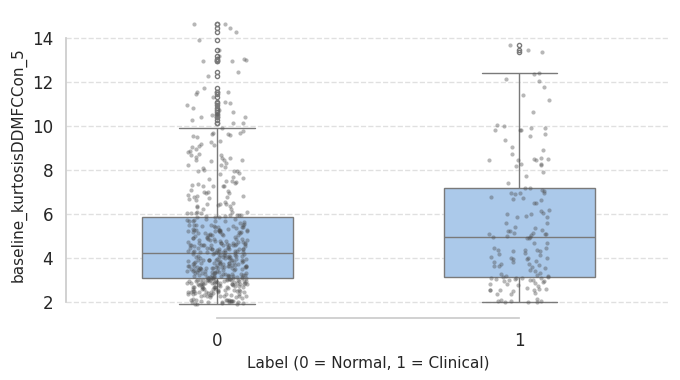

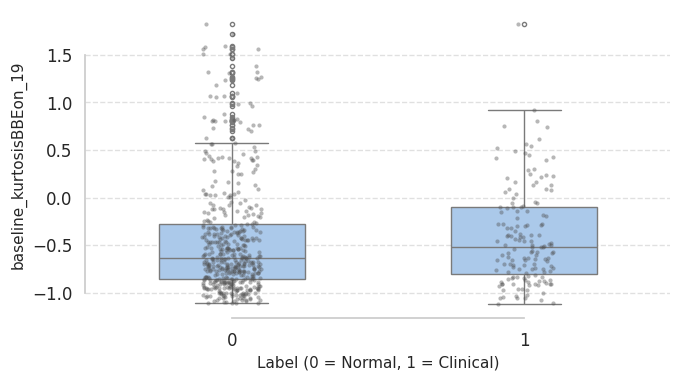

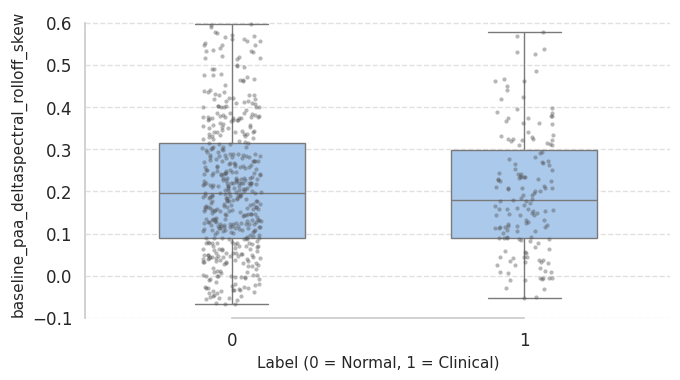

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", font_scale=1.1)
target = "YSR_93_98_ip"

top3 = (
    top_features_df[top_features_df["Target"] == target]
    .nlargest(3, "Coefficient")["Feature"]
    .tolist()
)

for feat in top3:
    if feat not in df.columns:
        print(f"⚠️ Feature {feat} not found.")
        continue

    # Remove extreme outliers robustly
    q_low, q_high = df[feat].quantile([0.05, 0.95])
    clean_df = df[(df[feat] >= q_low) & (df[feat] <= q_high)]

    if clean_df[feat].max() > 1e6:
        clean_df = clean_df[clean_df[feat] < 1e6]

    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x=target, y=feat, data=clean_df, width=0.5, fliersize=3)
    sns.stripplot(x=target, y=feat, data=clean_df, jitter=True, size=3, color=".3", alpha=0.4)
    ax.set_xlabel("Label (0 = Normal, 1 = Clinical)", fontsize=11)
    ax.set_ylabel(feat, fontsize=11)
    sns.despine(trim=True)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

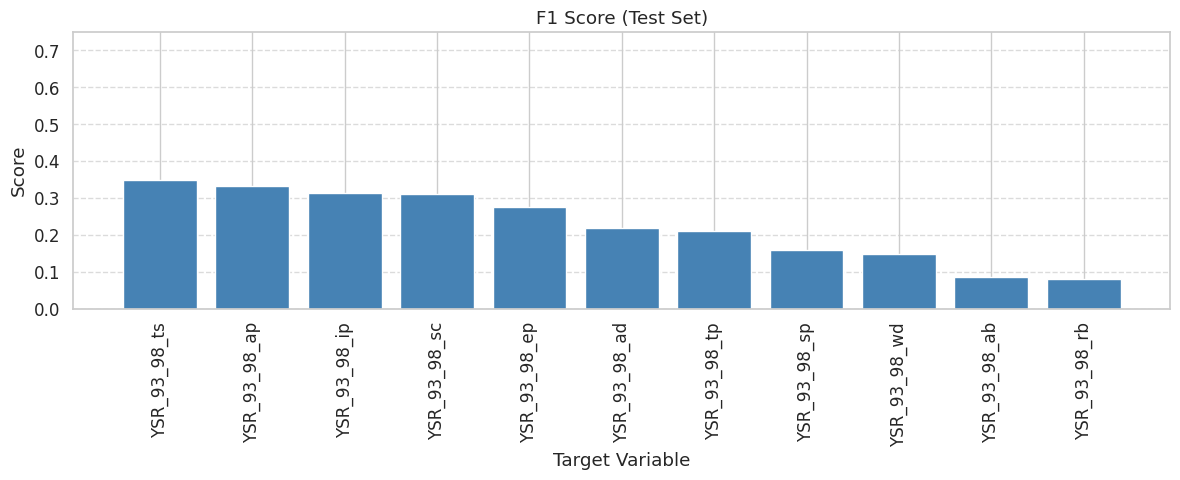

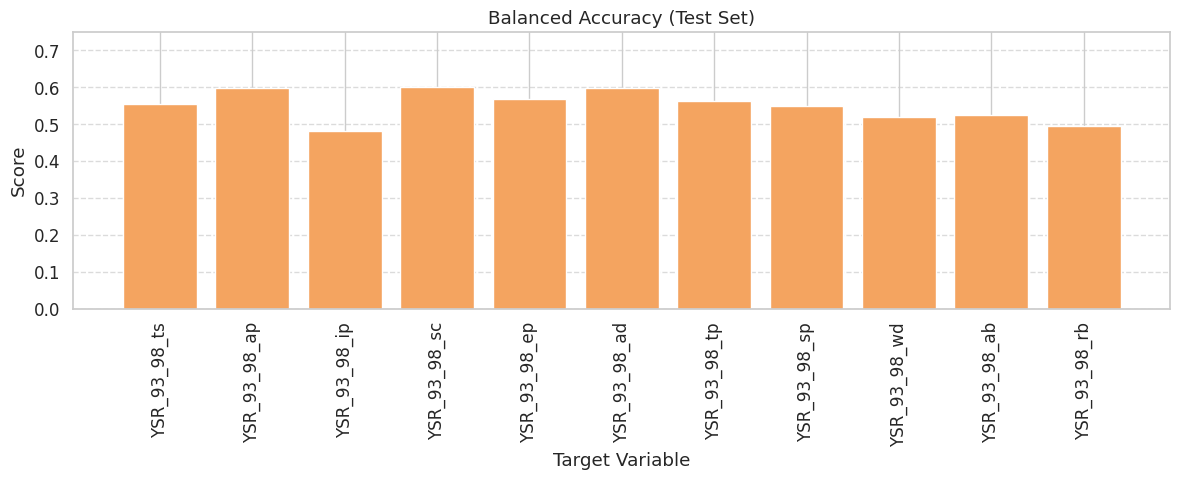

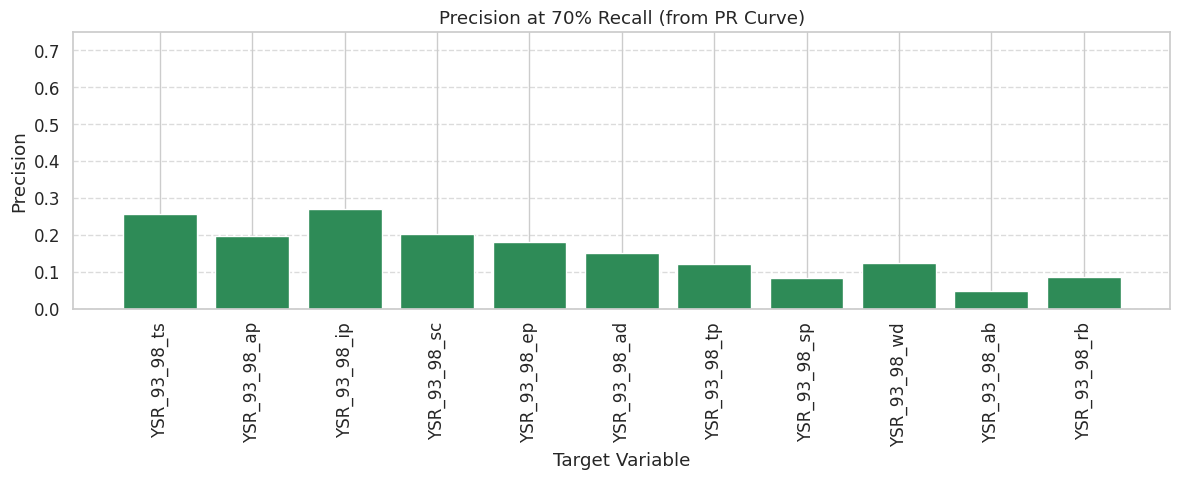

In [92]:
import matplotlib.pyplot as plt

def plot_metrics_same_order(df, sort_by="F1 (test)", ylim=(0, 0.75)):
    # Sort once and get consistent target order
    df_sorted = df.sort_values(sort_by, ascending=False)
    target_order = df_sorted["Target"]

    def plot_metric(metric_col, title, color, ylabel="Score"):
        values = df.set_index("Target").loc[target_order, metric_col]
        plt.figure(figsize=(12, 5))
        plt.bar(target_order, values, color=color)
        plt.title(title)
        plt.xlabel("Target Variable")
        plt.ylabel(ylabel)
        plt.xticks(rotation=90)
        plt.ylim(*ylim)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    # Plot all three metrics with same target order and y-limits
    plot_metric("F1 (test)", "F1 Score (Test Set)", "steelblue")
    plot_metric("Balanced Accuracy (test)", "Balanced Accuracy (Test Set)", "sandybrown")
    plot_metric("Precision@70%Recall", "Precision at 70% Recall (from PR Curve)", "seagreen", ylabel="Precision")

# Usage:
plot_metrics_same_order(final_results_df)


In [27]:
results=[]

for target in tqdm(target_columns):
    data = df[[target]].join(df[df.columns[77:]]).dropna()
    y = data[target]
    X = data[df.columns[77:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]

           # ----- Precision-Recall Curve -----
            precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

            # Compute F1 score for each threshold
            f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precisions, recalls)]

            # Only keep thresholds with sufficient precision AND recall
            min_precision = 0.3
            min_recall = 0.3

            valid_idxs = [
                i for i, (p, r) in enumerate(zip(precisions[:-1], recalls[:-1]))  # match len(thresholds)
                if p >= min_precision and r >= min_recall
            ]

            if valid_idxs:
                best_f1_idx = valid_idxs[np.argmax([f1_scores[i] for i in valid_idxs])]
                threshold = thresholds[best_f1_idx]
                best_f1 = f1_scores[best_f1_idx]
            else:
                print(f"⚠️ {model_name}: No threshold met precision ≥ {min_precision} and recall ≥ {min_recall}.")
                threshold = 0.5  # fallback
                best_f1 = np.nan



            print(f"Model: {model_name}")
            print(f"  Selected threshold for max F1: {threshold:.4f}")
            print(f"  Max F1 at threshold: {best_f1:.4f}")
            print(f"  y_proba sample: {np.round(y_proba[:5], 4)}")

            # Predict using selected threshold
            y_pred = (y_proba >= threshold).astype(int)
            prec_at_thresh = precision_score(y_test, y_pred, zero_division=0)
            recall_at_thresh = recall_score(y_test, y_pred, zero_division=0)

            # Define precision@70%recall (at chosen threshold only)
            precision_at_70recall = prec_at_thresh if recall_at_thresh >= 0.7 else np.nan

            # Test set metrics
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            # Cross-validation
            stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

            cv_metrics = cross_val_with_threshold_tuning(
            model, X, y,
            min_precision=0.3,
            min_recall=0.3,
            recall_target=0.7,
            n_splits=5
        )

        # --- Replace results.append block with this ---
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC Mean": np.nan,  # optional: keep if needed
                "ROC AUC Std": np.nan,   # or compute separately if wanted
                "PR AUC Mean": np.nan,
                "PR AUC Std": np.nan,
                "F1 Mean": cv_metrics["F1 Mean"],
                "F1 Std": cv_metrics["F1 Std"],
                "Balanced Accuracy Mean": cv_metrics["Balanced Accuracy Mean"],
                "Balanced Accuracy Std": cv_metrics["Balanced Accuracy Std"],
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1 (test)": f1,
                "Balanced Accuracy (test)": bal_acc,
                "Precision@70%Recall": precision_at_70recall,
                "Threshold Used": threshold,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "Threshold Used (CV Mean)": cv_metrics["Thresholds Used (Mean)"],
                "Precision@70%Recall (CV Mean)": cv_metrics["Precision@70%Recall Mean"]
            })

        except Exception as e:
            print(f"Model {model_name} failed on target {target} with error: {e}")

results_df = pd.DataFrame(results)
results_df.to_csv("12vars_STRATIFIED_CV_THRESHOLDING__BASELINE_FINAL.csv", index=False)


  0%|          | 0/11 [00:00<?, ?it/s]

⚠️ No FS - Balanced: No threshold met precision ≥ 0.3 and recall ≥ 0.3.
Model: No FS - Balanced
  Selected threshold for max F1: 0.5000
  Max F1 at threshold: nan
  y_proba sample: [0.00e+00 9.82e-01 0.00e+00 2.00e-04 1.00e-04]


/tmp/ipykernel_2537838/1268914624.py:60: RuntimeWarning: Mean of empty slice
  "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),


⚠️ No FS - SMOTE: No threshold met precision ≥ 0.3 and recall ≥ 0.3.
Model: No FS - SMOTE
  Selected threshold for max F1: 0.5000
  Max F1 at threshold: nan
  y_proba sample: [0.000e+00 9.903e-01 0.000e+00 1.000e-04 0.000e+00]


/tmp/ipykernel_2537838/1268914624.py:60: RuntimeWarning: Mean of empty slice
  "Precision@70%Recall Mean": np.nanmean(precisions_at_70recall),
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/l

⚠️ No FS - ElasticNet: No threshold met precision ≥ 0.3 and recall ≥ 0.3.
Model: No FS - ElasticNet
  Selected threshold for max F1: 0.5000
  Max F1 at threshold: nan
  y_proba sample: [0.4461 0.6553 0.3233 0.5649 0.4157]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KeyboardInterrupt: 

In [17]:
target_columns = ['YSR_93_98_ad', 'YSR_93_98_wd',
       'YSR_93_98_sc', 'YSR_93_98_sp', 'YSR_93_98_tp', 'YSR_93_98_ap',
       'YSR_93_98_rb', 'YSR_93_98_ab', 'YSR_93_98_ip', 'YSR_93_98_ep',
       'YSR_93_98_ts']
from sklearn.base import clone

import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import (
    roc_auc_score, average_precision_score, balanced_accuracy_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, precision_recall_curve
)
results = []

var_thresh = VarianceThreshold(threshold=0.0)
scaler = RobustScaler()
kbest = SelectKBest(score_func=mutual_info_classif, k=100)
pca = PCA(n_components=50)

scoring = {
    'roc_auc': 'roc_auc',
    'pr_auc': 'average_precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy'
}

for target in tqdm(target_columns):
    data = df[[target]].join(df[df.columns[79:]]).dropna()
    y = data[target]
    X = data[df.columns[79:]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

    models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ]),

        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - ElasticNet": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(
                Cs=10,
                penalty='elasticnet',
                solver='saga',
                l1_ratios=[0.5],
                class_weight='balanced',
                cv=5,
                scoring='average_precision',
                max_iter=2000,
                random_state=42
            ))
        ])
    }

    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            print(f"{model_name} y_proba sample:", y_proba[:5])

            precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
            idx = np.argmax(recalls >= 0.70)
            precision_at_70recall = precisions[idx] if idx < len(precisions) else np.nan

            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            bal_acc = balanced_accuracy_score(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
           
            cv_scores = cross_validate(
                clone(model),  # ✅ ensures a fresh, unfitted model
                X, y,
                scoring=scoring,
                cv=stratified_cv,
                return_train_score=False,
                error_score='raise',
                n_jobs=10
            )


            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC Mean": np.mean(cv_scores['test_roc_auc']),
                "ROC AUC Std": np.std(cv_scores['test_roc_auc']),
                "PR AUC Mean": np.mean(cv_scores['test_pr_auc']),
                "PR AUC Std": np.std(cv_scores['test_pr_auc']),
                "F1 Mean": np.mean(cv_scores['test_f1']),
                "F1 Std": np.std(cv_scores['test_f1']),
                "Balanced Accuracy Mean": np.mean(cv_scores['test_balanced_accuracy']),
                "Balanced Accuracy Std": np.std(cv_scores['test_balanced_accuracy']),
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1 (test)": f1,
                "Balanced Accuracy (test)": bal_acc,
                "Precision@70%Recall": precision_at_70recall,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC Mean": None,
                "ROC AUC Std": None,
                "PR AUC Mean": None,
                "PR AUC Std": None,
                "F1 Mean": None,
                "F1 Std": None,
                "Balanced Accuracy Mean": None,
                "Balanced Accuracy Std": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1 (test)": None,
                "Balanced Accuracy (test)": None,
                "Precision@70%Recall": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

results_df = pd.DataFrame(results)
results_df.to_csv("12vars_STRATIFIED_CV_BASELINE.csv", index=False)

  0%|          | 0/11 [00:00<?, ?it/s]

No FS - Balanced y_proba sample: [2.11447220e-07 9.93414674e-01 3.42901540e-05 3.56518300e-04
 1.95497578e-04]
No FS - SMOTE y_proba sample: [1.14186094e-08 9.96703345e-01 1.48445644e-05 1.26965355e-04
 9.48798472e-05]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.43940924 0.62118789 0.3823703  0.55706909 0.46924358]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.05190329 0.94281964 0.20457489 0.17324897 0.00258804]
KBest - SMOTE y_proba sample: [7.59845190e-03 9.96337217e-01 1.44457446e-01 2.56866108e-01
 7.01162770e-04]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.14044294 0.56029832 0.31498794 0.66561665 0.26246507]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [1.01302079e-04 9.43860675e-01 2.81885582e-01 3.92915489e-01
 5.11506749e-01]
PCA - SMOTE y_proba sample: [5.32196984e-06 9.62709000e-01 4.24403858e-01 4.60170314e-01
 6.63540280e-01]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.64447484 0.64831495 0.42103746 0.60559532 0.48230743]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [5.00666318e-01 2.57582907e-01 1.01853428e-03 1.94215343e-04
 1.07539734e-04]
No FS - SMOTE y_proba sample: [4.21836826e-01 1.73761217e-01 5.82452264e-04 6.30131596e-05
 6.39170843e-05]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.52764867 0.48828171 0.50349434 0.28130436 0.50116225]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.77749424 0.12839152 0.05172156 0.95697184 0.95596871]
KBest - SMOTE y_proba sample: [0.27159373 0.20633079 0.00927902 0.96099622 0.93961848]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.62022383 0.54772519 0.3130562  0.73824873 0.60700577]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.52409243 0.19227485 0.58366971 0.12463902 0.41236179]
PCA - SMOTE y_proba sample: [0.36306771 0.06132092 0.68982775 0.06031565 0.37895779]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.48820732 0.48195899 0.55211787 0.40334558 0.56585871]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [1.06076234e-03 5.15574193e-07 3.89693592e-02 4.90817750e-06
 1.56556221e-04]
No FS - SMOTE y_proba sample: [4.33655857e-04 7.84833341e-08 1.94243505e-02 1.69306077e-06
 7.97842266e-05]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.46123403 0.25629818 0.5039731  0.34489382 0.34274796]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.06375554 0.00136812 0.39159078 0.02099851 0.19961374]
KBest - SMOTE y_proba sample: [0.2481606  0.00568584 0.03641038 0.00128603 0.06349999]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.44608864 0.24880291 0.28163756 0.19649006 0.46707051]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.70956732 0.14554831 0.3019743  0.19466338 0.28155889]
PCA - SMOTE y_proba sample: [0.82588619 0.10213842 0.27138074 0.16174794 0.18433672]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.6642958  0.4131249  0.54334945 0.47210213 0.50095084]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [3.64183476e-04 6.59752035e-02 4.99523262e-03 8.21088822e-04
 3.09312469e-12]
No FS - SMOTE y_proba sample: [1.95756091e-04 4.76745117e-02 3.50409758e-03 1.40198592e-03
 1.80941986e-13]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [2.52663763e-01 2.71678001e-01 5.04086459e-01 1.37165782e-01
 2.23592442e-04]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [5.75359863e-02 5.87225121e-01 8.67640186e-01 3.61050455e-06
 9.60952034e-02]
KBest - SMOTE y_proba sample: [4.51594788e-02 2.97246645e-01 7.91961840e-01 1.48489955e-08
 3.07732730e-03]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.51032026 0.64754016 0.72978288 0.07197935 0.51124394]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.35011025 0.2849208  0.61792267 0.49785673 0.00558676]
PCA - SMOTE y_proba sample: [0.2587242  0.18112569 0.59850225 0.36767583 0.00929441]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.52755973 0.55365633 0.55343532 0.41889552 0.04658037]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [5.37857469e-04 3.01815851e-08 1.48653732e-06 7.38245158e-01
 8.92074221e-06]
No FS - SMOTE y_proba sample: [3.68820139e-04 8.14491633e-10 4.35811694e-07 7.39435771e-01
 4.12546633e-06]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.39152934 0.03666028 0.13959425 0.76285285 0.18366703]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.01348033 0.02622393 0.00110687 0.00373414 0.16266904]
KBest - SMOTE y_proba sample: [0.00132483 0.00382878 0.00340908 0.00026236 0.11965261]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.3223814  0.13397096 0.0910353  0.14097902 0.36236999]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.72071387 0.25412354 0.33823043 0.72820951 0.28378646]
PCA - SMOTE y_proba sample: [0.83009575 0.0020544  0.30171101 0.72648359 0.39698982]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.54811846 0.33395805 0.55696624 0.71509655 0.44439429]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [1.70065067e-01 8.51781105e-08 3.48962425e-04 6.29340491e-05
 2.26376310e-07]
No FS - SMOTE y_proba sample: [1.86874620e-01 5.33594113e-10 1.11792038e-04 2.06995290e-05
 4.13567571e-08]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.44184134 0.81051658 0.38862816 0.45241423 0.40659551]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.86130642 0.87902785 0.0820689  0.33965515 0.04903265]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KBest - SMOTE y_proba sample: [0.84637379 0.61930498 0.07192853 0.27336253 0.02824442]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.

KBest - ElasticNet y_proba sample: [0.61093457 0.53368802 0.28992726 0.23101095 0.11313592]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.40911009 0.93703827 0.24333589 0.46116736 0.54541823]
PCA - SMOTE y_proba sample: [0.45092225 0.55716297 0.19998995 0.4557244  0.56775047]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.49583476 0.85337613 0.38066272 0.51136703 0.5046408 ]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [3.01573359e-03 6.34055678e-02 2.43265391e-04 4.15966267e-08
 2.88086145e-03]
No FS - SMOTE y_proba sample: [1.60026234e-03 7.20556411e-02 5.13459061e-05 6.21293618e-09
 1.92997772e-03]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.21157072 0.37813633 0.64954404 0.38163172 0.56526918]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [1.77819809e-03 7.29000088e-02 3.44130508e-05 1.44566063e-06
 1.18223646e-01]
KBest - SMOTE y_proba sample: [2.18835689e-02 3.20803848e-02 4.93502499e-07 6.05304357e-08
 3.42077344e-02]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.22925419 0.51274179 0.25714982 0.03024842 0.37378126]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [7.62859512e-03 2.92328353e-05 1.98869754e-01 5.50023957e-03
 4.70740552e-01]
PCA - SMOTE y_proba sample: [3.27412808e-03 3.16829626e-06 3.49529069e-02 7.08500088e-03
 5.25865987e-01]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.34789153 0.47127132 0.82982817 0.70658245 0.66931144]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [6.85766898e-03 4.32925084e-04 1.74616895e-05 6.07475033e-05
 2.73507207e-03]
No FS - SMOTE y_proba sample: [4.70144024e-03 1.91806842e-04 8.37939859e-06 2.02178688e-05
 9.04830023e-04]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.44333936 0.38122195 0.25902167 0.2398968  0.40555016]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [6.99464516e-01 2.51232550e-05 1.88720691e-03 4.04965650e-07
 1.84388229e-02]
KBest - SMOTE y_proba sample: [6.05658126e-01 1.26947290e-06 7.38123783e-04 1.72717172e-07
 1.48199793e-02]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.72085072 0.03937403 0.09687656 0.00131039 0.04939183]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [8.07097243e-01 3.82650434e-01 2.52210900e-04 2.13002977e-03
 5.23998699e-01]
PCA - SMOTE y_proba sample: [9.09988836e-01 4.69982958e-01 1.19875083e-04 3.26756668e-04
 3.67862539e-01]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.50705468 0.51190294 0.51037647 0.5110824  0.51294686]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [9.81677607e-01 9.10159085e-03 2.25715470e-02 3.27788712e-01
 4.06938156e-04]
No FS - SMOTE y_proba sample: [9.82094466e-01 4.44080176e-03 1.27042724e-02 3.36170301e-01
 1.23666264e-04]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.66609276 0.47193433 0.43889064 0.55803405 0.37990575]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.47140918 0.02327959 0.45607639 0.48324561 0.02725476]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KBest - SMOTE y_proba sample: [0.58738189 0.00772183 0.53270342 0.77518628 0.01171804]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

KBest - ElasticNet y_proba sample: [0.53510163 0.46334996 0.47611684 0.5411914  0.45922496]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.70785368 0.23607773 0.42575438 0.5728589  0.29000111]
PCA - SMOTE y_proba sample: [0.66368066 0.24789202 0.42140427 0.61970978 0.24757967]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.52191055 0.44610347 0.46848317 0.53931885 0.44612089]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [1.10653627e-02 7.12432568e-04 2.59010821e-06 7.84213635e-05
 4.83866868e-01]
No FS - SMOTE y_proba sample: [9.33178677e-03 5.40641457e-04 7.27014080e-07 1.57124827e-05
 6.74044393e-01]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.48440787 0.18907905 0.1901341  0.19770077 0.52143542]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.04322511 0.03844038 0.13257588 0.85942959 0.71169878]
KBest - SMOTE y_proba sample: [0.01665715 0.18193285 0.01072409 0.65872815 0.67783823]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.02507106 0.1425724  0.08852143 0.63405896 0.5722479 ]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.72217914 0.06044793 0.37201736 0.32615137 0.39870224]
PCA - SMOTE y_proba sample: [0.77312231 0.08759558 0.22137771 0.48254686 0.54886334]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.57610402 0.43719126 0.50095074 0.53577734 0.57361588]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - Balanced y_proba sample: [3.49505186e-04 5.19653858e-06 4.39494005e-03 8.62270586e-01
 2.01993910e-02]
No FS - SMOTE y_proba sample: [1.99675813e-04 5.37058264e-07 2.15805901e-03 8.44855720e-01
 1.31120830e-02]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

No FS - ElasticNet y_proba sample: [0.38785872 0.22453665 0.28991411 0.46877673 0.34897837]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - Balanced y_proba sample: [0.91433564 0.30148354 0.66617669 0.03354835 0.93098407]
KBest - SMOTE y_proba sample: [0.97702625 0.50204484 0.59692035 0.0083526  0.89043969]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

KBest - ElasticNet y_proba sample: [0.52728157 0.64066271 0.48644761 0.41843807 0.58626582]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - Balanced y_proba sample: [0.50797536 0.21994339 0.44928935 0.33004722 0.2916381 ]
PCA - SMOTE y_proba sample: [0.46343916 0.09339023 0.28484788 0.36605594 0.35082635]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

PCA - ElasticNet y_proba sample: [0.48192281 0.50181544 0.50033804 0.50122287 0.499065  ]


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

In [44]:
target_col = 'YSR_93_98_ad'

df_filtered = df[[target_col]].join(df[df.columns[77:]])

df_filtered = df_filtered.dropna()

y = df_filtered[target_col]
X = df_filtered[df.columns[79:]]

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [46]:
###removing constant features
###using robust scaler as it is resistant to outliers
#####this is a shared pre processing pipeline

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold

preprocessor = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler())
])

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Pipeline with preprocessing + logistic regression
pipe_balanced = Pipeline([
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Fit model
pipe_balanced.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipe_balanced.predict(X_test)
y_proba = pipe_balanced.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       108
           1       0.11      0.09      0.10        11

    accuracy                           0.85       119
   macro avg       0.51      0.51      0.51       119
weighted avg       0.84      0.85      0.84       119

ROC AUC: 0.6220538720538721


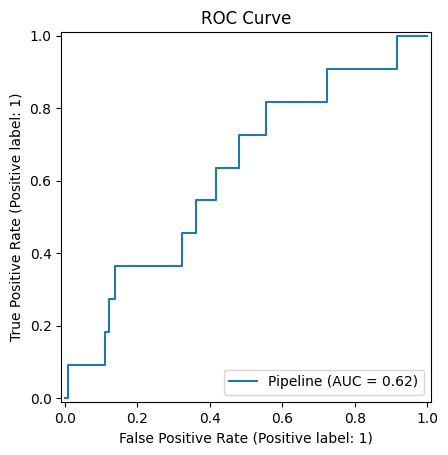

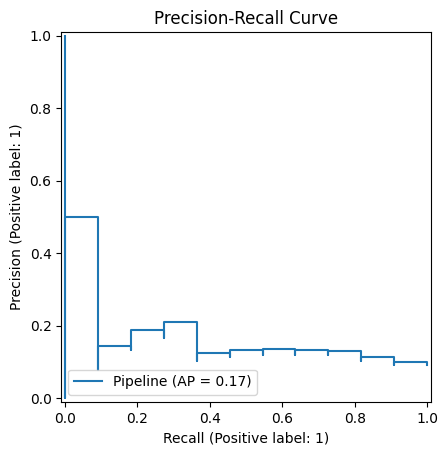

In [48]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt

# ROC Curve
RocCurveDisplay.from_estimator(pipe_balanced, X_test, y_test)
plt.title("ROC Curve")
plt.show()

# PR Curve
PrecisionRecallDisplay.from_estimator(pipe_balanced, X_test, y_test)
plt.title("Precision-Recall Curve")
plt.show()

In [49]:
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipe_smote = ImbPipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_smote.fit(X_train, y_train)
y_pred_smote = pipe_smote.predict(X_test)
y_proba_smote = pipe_smote.predict_proba(X_test)[:, 1]

print("SMOTE + Logistic Regression")
print(classification_report(y_test, y_pred_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_smote))

SMOTE + Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       108
           1       0.11      0.09      0.10        11

    accuracy                           0.85       119
   macro avg       0.51      0.51      0.51       119
weighted avg       0.84      0.85      0.84       119

ROC AUC: 0.6178451178451179


In [50]:
from sklearn.linear_model import LogisticRegressionCV

pipe_l1 = Pipeline([
    ('preprocessing', preprocessor),
    ('logreg', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        cv=5,
        scoring='roc_auc',
        random_state=42
    ))
])

pipe_l1.fit(X_train, y_train)
y_pred_l1 = pipe_l1.predict(X_test)
y_proba_l1 = pipe_l1.predict_proba(X_test)[:, 1]

print("L1-Regularized Logistic Regression")
print(classification_report(y_test, y_pred_l1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_l1))


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

L1-Regularized Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.80      0.86       108
           1       0.19      0.45      0.26        11

    accuracy                           0.76       119
   macro avg       0.56      0.63      0.56       119
weighted avg       0.87      0.76      0.80       119

ROC AUC: 0.6919191919191919


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Balanced Logistic Regression + SelectKBest
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       108
           1       0.14      0.45      0.22        11

    accuracy                           0.70       119
   macro avg       0.54      0.59      0.51       119
weighted avg       0.86      0.70      0.76       119

ROC AUC: 0.6632996632996633
SMOTE + Logistic Regression + SelectKBest
              precision    recall  f1-score   support

           0       0.95      0.80      0.86       108
           1       0.21      0.55      0.31        11

    accuracy                           0.77       119
   macro avg       0.58      0.67      0.59       119
weighted avg       0.88      0.77      0.81       119

ROC AUC: 0.7474747474747475


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

L1-Regularized Logistic Regression + SelectKBest
              precision    recall  f1-score   support

           0       0.95      0.73      0.83       108
           1       0.19      0.64      0.30        11

    accuracy                           0.72       119
   macro avg       0.57      0.68      0.56       119
weighted avg       0.88      0.72      0.78       119

ROC AUC: 0.7407407407407408


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


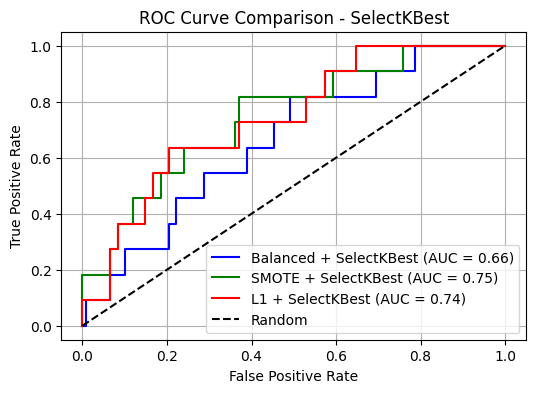

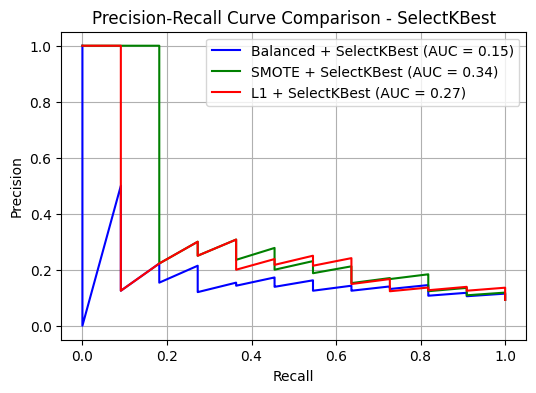

In [56]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Choose top k acoustic features
k = 100  # Try different values like 50, 100, 200...

feature_selector = SelectKBest(score_func=mutual_info_classif, k=k)

preprocessor_kbest = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('select', feature_selector)
])
### balanced logistic regression

from sklearn.linear_model import LogisticRegression

pipe_kbest_balanced = Pipeline([
    ('preprocessing', preprocessor_kbest),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

pipe_kbest_balanced.fit(X_train, y_train)
y_pred_kbest_balanced = pipe_kbest_balanced.predict(X_test)
y_proba_kbest_balanced = pipe_kbest_balanced.predict_proba(X_test)[:, 1]

print("Balanced Logistic Regression + SelectKBest")
print(classification_report(y_test, y_pred_kbest_balanced))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kbest_balanced))

### smote

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

pipe_kbest_smote = ImbPipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('select', SelectKBest(score_func=mutual_info_classif, k=k)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_kbest_smote.fit(X_train, y_train)
y_pred_kbest_smote = pipe_kbest_smote.predict(X_test)
y_proba_kbest_smote = pipe_kbest_smote.predict_proba(X_test)[:, 1]

print("SMOTE + Logistic Regression + SelectKBest")
print(classification_report(y_test, y_pred_kbest_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kbest_smote))

### L1

from sklearn.linear_model import LogisticRegressionCV

pipe_kbest_l1 = Pipeline([
    ('preprocessing', preprocessor_kbest),
    ('logreg', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        cv=5,
        scoring='roc_auc',
        random_state=42
    ))
])

pipe_kbest_l1.fit(X_train, y_train)
y_pred_kbest_l1 = pipe_kbest_l1.predict(X_test)
y_proba_kbest_l1 = pipe_kbest_l1.predict_proba(X_test)[:, 1]

print("L1-Regularized Logistic Regression + SelectKBest")
print(classification_report(y_test, y_pred_kbest_l1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_kbest_l1))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# SelectKBest comparison
kbest_names = ['Balanced + SelectKBest', 'SMOTE + SelectKBest', 'L1 + SelectKBest']
kbest_probs = [y_proba_kbest_balanced, y_proba_kbest_smote, y_proba_kbest_l1]
kbest_colors = ['blue', 'green', 'red']

# ROC Curve
plt.figure(figsize=(6, 4))
for name, prob, color in zip(kbest_names, kbest_probs, kbest_colors):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - SelectKBest')
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
plt.figure(figsize=(6, 4))
for name, prob, color in zip(kbest_names, kbest_probs, kbest_colors):
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})', color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison - SelectKBest')
plt.legend()
plt.grid(True)
plt.show()


Balanced Logistic Regression + PCA
              precision    recall  f1-score   support

           0       0.93      0.76      0.84       108
           1       0.16      0.45      0.24        11

    accuracy                           0.73       119
   macro avg       0.55      0.61      0.54       119
weighted avg       0.86      0.73      0.78       119

ROC AUC: 0.6430976430976432
SMOTE + Logistic Regression + PCA
              precision    recall  f1-score   support

           0       0.92      0.75      0.83       108
           1       0.13      0.36      0.19        11

    accuracy                           0.71       119
   macro avg       0.52      0.56      0.51       119
weighted avg       0.85      0.71      0.77       119

ROC AUC: 0.6414141414141414


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

L1-Regularized Logistic Regression + PCA
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       108
           1       0.13      0.45      0.20        11

    accuracy                           0.67       119
   macro avg       0.53      0.57      0.50       119
weighted avg       0.85      0.67      0.74       119

ROC AUC: 0.6464646464646464


/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


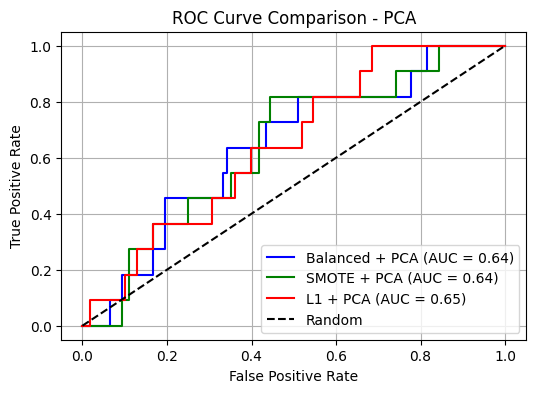

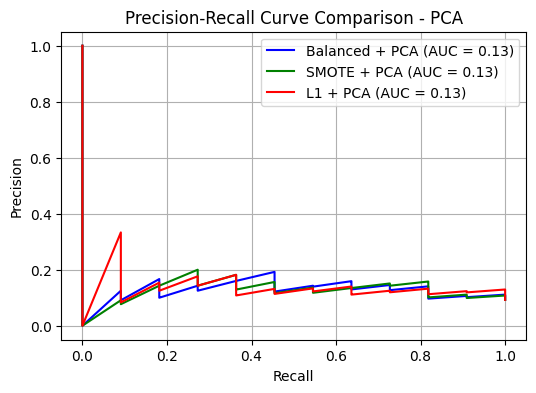

In [57]:
from sklearn.decomposition import PCA

n_components = 50  # Try 20, 50, 100
preprocessor_pca = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=n_components))
])

###balanced class weight

pipe_pca_balanced = Pipeline([
    ('preprocessing', preprocessor_pca),
    ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

pipe_pca_balanced.fit(X_train, y_train)
y_pred_pca_balanced = pipe_pca_balanced.predict(X_test)
y_proba_pca_balanced = pipe_pca_balanced.predict_proba(X_test)[:, 1]

print("Balanced Logistic Regression + PCA")
print(classification_report(y_test, y_pred_pca_balanced))
print("ROC AUC:", roc_auc_score(y_test, y_proba_pca_balanced))

### smote

pipe_pca_smote = ImbPipeline([
    ('var_thresh', VarianceThreshold(threshold=0.0)),
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=n_components)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])

pipe_pca_smote.fit(X_train, y_train)
y_pred_pca_smote = pipe_pca_smote.predict(X_test)
y_proba_pca_smote = pipe_pca_smote.predict_proba(X_test)[:, 1]

print("SMOTE + Logistic Regression + PCA")
print(classification_report(y_test, y_pred_pca_smote))
print("ROC AUC:", roc_auc_score(y_test, y_proba_pca_smote))

##### L1
pipe_pca_l1 = Pipeline([
    ('preprocessing', preprocessor_pca),
    ('logreg', LogisticRegressionCV(
        Cs=10,
        penalty='l1',
        solver='saga',
        class_weight='balanced',
        max_iter=2000,
        cv=5,
        scoring='roc_auc',
        random_state=42
    ))
])

pipe_pca_l1.fit(X_train, y_train)
y_pred_pca_l1 = pipe_pca_l1.predict(X_test)
y_proba_pca_l1 = pipe_pca_l1.predict_proba(X_test)[:, 1]

print("L1-Regularized Logistic Regression + PCA")
print(classification_report(y_test, y_pred_pca_l1))
print("ROC AUC:", roc_auc_score(y_test, y_proba_pca_l1))

# PCA comparison
pca_names = ['Balanced + PCA', 'SMOTE + PCA', 'L1 + PCA']
pca_probs = [y_proba_pca_balanced, y_proba_pca_smote, y_proba_pca_l1]
pca_colors = ['blue', 'green', 'red']

# ROC Curve
plt.figure(figsize=(6,4))
for name, prob, color in zip(pca_names, pca_probs, pca_colors):
    fpr, tpr, _ = roc_curve(y_test, prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', color=color)
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison - PCA')
plt.legend()
plt.grid(True)
plt.show()

# PR Curve
plt.figure(figsize=(6,4))
for name, prob, color in zip(pca_names, pca_probs, pca_colors):
    precision, recall, _ = precision_recall_curve(y_test, prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.2f})', color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison - PCA')
plt.legend()
plt.grid(True)
plt.show()


# results of all targets

In [25]:
target_columns = ['YSR_93_98_ad', 'YSR_93_98_wd',
       'YSR_93_98_sc', 'YSR_93_98_sp', 'YSR_93_98_tp', 'YSR_93_98_ap',
       'YSR_93_98_rb', 'YSR_93_98_ab', 'YSR_93_98_ip', 'YSR_93_98_ep',
       'YSR_93_98_ts']

In [26]:
positive_class_ratios = df[target_columns].mean()

# Display the result
print(positive_class_ratios)


YSR_93_98_ad    0.099010
YSR_93_98_wd    0.111740
YSR_93_98_sc    0.147100
YSR_93_98_sp    0.087694
YSR_93_98_tp    0.104668
YSR_93_98_ap    0.171146
YSR_93_98_rb    0.067893
YSR_93_98_ab    0.042433
YSR_93_98_ip    0.247525
YSR_93_98_ep    0.138614
YSR_93_98_ts    0.220651
dtype: float64


In [30]:
df.columns[77:]

Index(['baseline_avgDF0', 'baseline_avgDDF0', 'baseline_avgJitter',
       'baseline_avgShimmer', 'baseline_avgapq', 'baseline_avgppq',
       'baseline_avglogE', 'baseline_stdDF0', 'baseline_stdDDF0',
       'baseline_stdJitter',
       ...
       'baseline_paa_deltachroma_12_min', 'baseline_paa_deltachroma_12_max',
       'baseline_paa_deltachroma_12_skew',
       'baseline_paa_deltachroma_12_kurtosis',
       'baseline_paa_deltachroma_std_mean', 'baseline_paa_deltachroma_std_std',
       'baseline_paa_deltachroma_std_min', 'baseline_paa_deltachroma_std_max',
       'baseline_paa_deltachroma_std_skew',
       'baseline_paa_deltachroma_std_kurtosis'],
      dtype='object', length=1027)

In [ ]:
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
from tqdm import tqdm

results = []

for target in tqdm(target_columns):
    # Step 1: Filter out rows with NaN in target or acoustic features
    data = df[[target]].join(df[df.columns[77:]]).dropna()
    y = data[target]
    X = data[df.columns[77:]]

    # Skip if there’s not enough variation
    if y.nunique() < 2:
        continue

    # Step 2: Train/Test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 3: Shared blocks
    var_thresh = VarianceThreshold(threshold=0.0)
    scaler = RobustScaler()
    kbest = SelectKBest(score_func=mutual_info_classif, k=100)
    pca = PCA(n_components=50)

    # Step 4: Build 9 pipelines
    models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
    }

    # Step 5: Fit and evaluate each model
    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_proba)

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": auc
            })
        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": None,
                "Error": str(e)
            })

# Save to CSV
results_df_baseline = pd.DataFrame(results)
results_df_baseline.to_csv("logistic_regression_test_split_results.csv", index=False)
results_df_baseline.sort_values(by=["Target", "ROC AUC"], ascending=[True, False])


In [16]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

results = []

for target in tqdm(target_columns):
    # Step 1: Filter rows with NaNs
    data = df[[target]].join(df[df.columns[77:]]).dropna()
    y = data[target]
    X = data[df.columns[77:]]

    # Skip if target has no variation
    if y.nunique() < 2:
        continue

    # Step 2: Train/Test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 3: Shared preprocessors
    var_thresh = VarianceThreshold(threshold=0.0)
    scaler = RobustScaler()
    kbest = SelectKBest(score_func=mutual_info_classif, k=100)
    pca = PCA(n_components=50)

    # Step 4: Define 9 model variants
    models = {
        "No FS - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "No FS - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "No FS - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "KBest - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('kbest', kbest),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - Balanced": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - SMOTE": ImbPipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('smote', SMOTE(random_state=42)),
            ('logreg', LogisticRegression(max_iter=1000, random_state=42))
        ]),
        "PCA - L1": Pipeline([
            ('var', var_thresh),
            ('scaler', scaler),
            ('pca', pca),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
    }

    # Step 5: Fit + Evaluate each model
    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            # Evaluation metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            pr_auc = average_precision_score(y_test, y_proba)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": None,
                "PR AUC": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

# Save final results
results_df_complete = pd.DataFrame(results)
results_df_complete.to_csv("logistic_regression_metrics_all_targets_CORRECT.csv", index=False)

# Optional: display top models per target
display(results_df_complete.sort_values(by=["Target", "ROC AUC"], ascending=[True, False]))


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

Target             Model   ROC AUC    PR AUC  Accuracy  Precision  \
71  YSR_93_98_ab          PCA - L1  0.668421  0.256437  0.168067   0.048077   
66  YSR_93_98_ab  KBest - Balanced  0.585965  0.117915  0.882353   0.090909   
67  YSR_93_98_ab     KBest - SMOTE  0.584211  0.086180  0.890756   0.100000   
68  YSR_93_98_ab        KBest - L1  0.570175  0.062672  0.512605   0.065574   
69  YSR_93_98_ab    PCA - Balanced  0.485965  0.135670  0.840336   0.062500   
..           ...               ...       ...       ...       ...        ...   
10  YSR_93_98_wd     No FS - SMOTE  0.568940  0.222328  0.815126   0.153846   
9   YSR_93_98_wd  No FS - Balanced  0.552975  0.178024  0.806723   0.142857   
14  YSR_93_98_wd        KBest - L1  0.531205  0.167950  0.672269   0.093750   
12  YSR_93_98_wd  KBest - Balanced  0.493469  0.115484  0.722689   0.045455   
13  YSR_93_98_wd     KBest - SMOTE  0.493469  0.130344  0.747899   0.095238   

      Recall        F1  TP   TN  FP  FN  
71  1.000000  0.091743   5   15  99   0  
66  0.200000  0.125000   1  104  10   4  
67  0.200000  0.133333   1  105   9   4  
68  0.800000  0.121212   4   57  57   1  
69  0.200000  0.095238   1   99  15   4  
..       ...       ...  ..  ...  ..  ..  
10  0.153846  0.153846   2   95  11  11  
9   0.153846  0.148148   2   94  12  11  
14  0.230769  0.133333   3   77  29  10  
12  0.076923  0.057143   1   85  21  12  
13  0.153846  0.117647   2   87  19  11  

[99 rows x 12 columns]

In [18]:
import pandas as pd

df_results = pd.read_csv("logistic_regression_metrics_all_targets_CORRECT.csv")

In [19]:
best_models = (
    df_results
    .sort_values(by="ROC AUC", ascending=False)
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)


In [20]:
display(best_models[["Target", "Model", "ROC AUC", "PR AUC", "F1"]])

Target             Model   ROC AUC    PR AUC        F1
0   YSR_93_98_ad  KBest - Balanced  0.728114  0.328366  0.200000
1   YSR_93_98_wd       PCA - SMOTE  0.698839  0.399424  0.285714
2   YSR_93_98_ab          PCA - L1  0.668421  0.256437  0.091743
3   YSR_93_98_sc    PCA - Balanced  0.652365  0.233873  0.338983
4   YSR_93_98_rb  KBest - Balanced  0.626276  0.091034  0.074074
5   YSR_93_98_ip     No FS - SMOTE  0.620599  0.314600  0.343750
6   YSR_93_98_ap  KBest - Balanced  0.614141  0.224405  0.371429
7   YSR_93_98_ep          PCA - L1  0.609573  0.257941  0.268041
8   YSR_93_98_sp  KBest - Balanced  0.602020  0.224235  0.142857
9   YSR_93_98_ts  KBest - Balanced  0.584367  0.254693  0.311688
10  YSR_93_98_tp  No FS - Balanced  0.556854  0.133437  0.200000

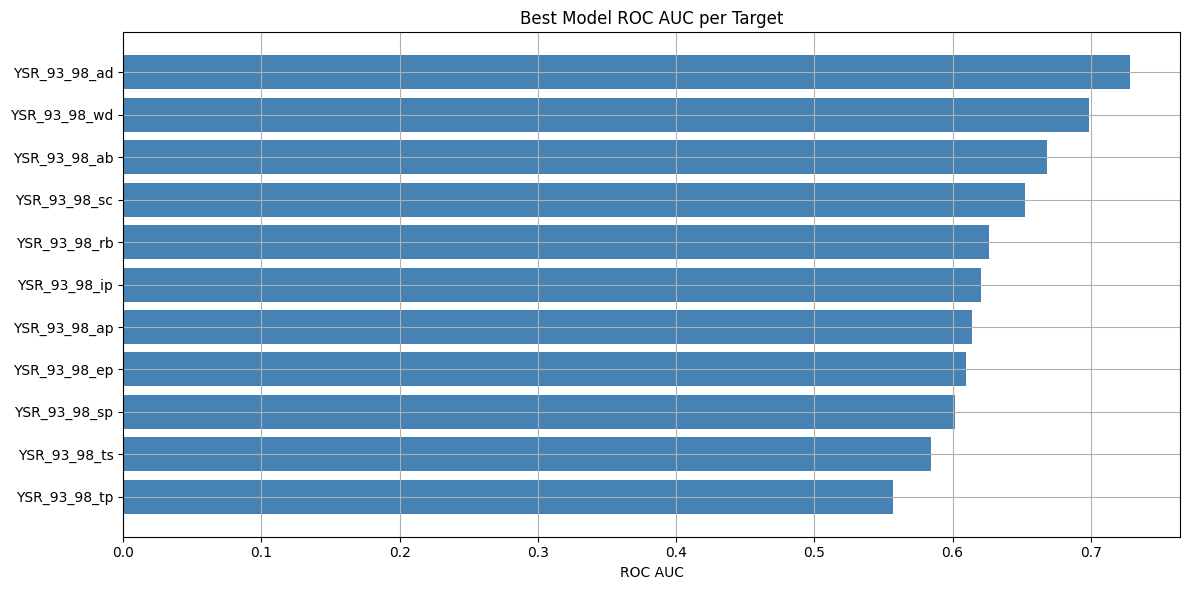

In [21]:
import matplotlib.pyplot as plt

# Sort for better visualization
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(best_models_sorted["Target"], best_models_sorted["ROC AUC"], color='steelblue')
plt.xlabel("ROC AUC")
plt.title("Best Model ROC AUC per Target")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()


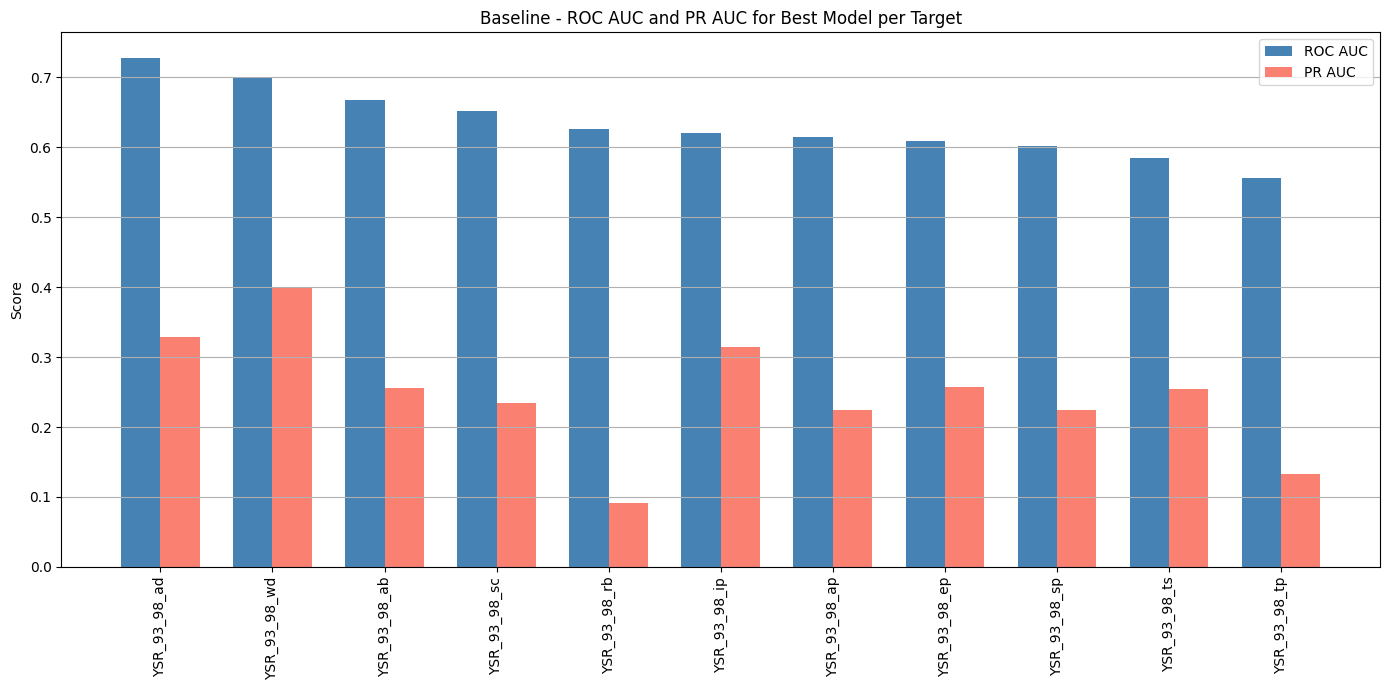

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC for cleaner plotting
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

targets = best_models_sorted["Target"]
x = np.arange(len(targets))

roc_auc = best_models_sorted["ROC AUC"]
pr_auc = best_models_sorted["PR AUC"]

width = 0.35  # width of bars

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, roc_auc, width, label='ROC AUC', color='steelblue')
plt.bar(x + width/2, pr_auc, width, label='PR AUC', color='salmon')

plt.xticks(x, targets, rotation=90)
plt.ylabel("Score")
plt.title("Baseline - ROC AUC and PR AUC for Best Model per Target")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


In [23]:
# Filter valid models
df_valid = df_results.dropna(subset=["PR AUC", "F1"])

# Choose best by PR AUC, break ties with F1
best_models = (
    df_valid
    .sort_values(by=["Target", "PR AUC", "F1"], ascending=[True, False, False])
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)


In [24]:
best_models

Target             Model   ROC AUC    PR AUC  Accuracy  Precision  \
0   YSR_93_98_ab          PCA - L1  0.668421  0.256437  0.168067   0.048077   
1   YSR_93_98_ad  KBest - Balanced  0.728114  0.328366  0.731092   0.137931   
2   YSR_93_98_ap  KBest - Balanced  0.614141  0.224405  0.630252   0.260000   
3   YSR_93_98_ep       PCA - SMOTE  0.558824  0.265198  0.605042   0.159091   
4   YSR_93_98_ip     No FS - SMOTE  0.620599  0.314600  0.647059   0.323529   
5   YSR_93_98_rb     KBest - SMOTE  0.581633  0.102534  0.823529   0.111111   
6   YSR_93_98_sc     KBest - SMOTE  0.613311  0.234508  0.705882   0.242424   
7   YSR_93_98_sp  KBest - Balanced  0.602020  0.224235  0.798319   0.105263   
8   YSR_93_98_tp  KBest - Balanced  0.551402  0.144429  0.722689   0.137931   
9   YSR_93_98_ts        No FS - L1  0.473118  0.282065  0.554622   0.235294   
10  YSR_93_98_wd       PCA - SMOTE  0.698839  0.399424  0.705882   0.194444   

      Recall        F1  TP  TN  FP  FN  
0   1.000000  0.091743   5  15  99   0  
1   0.363636  0.200000   4  83  25   7  
2   0.650000  0.371429  13  62  37   7  
3   0.411765  0.229508   7  65  37  10  
4   0.366667  0.343750  11  66  23  19  
5   0.285714  0.160000   2  96  16   5  
6   0.444444  0.313725   8  76  25  10  
7   0.222222  0.142857   2  93  17   7  
8   0.333333  0.195122   4  82  25   8  
9   0.461538  0.311688  12  54  39  14  
10  0.538462  0.285714   7  77  29   6

# attempting undersampling

In [32]:
import pandas as pd
import numpy as np
from tqdm import tqdm

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

results = []

for target in tqdm(target_columns):
    # Step 1: Filter rows with NaNs
    data = df[[target]].join(df[df.columns[77:]]).dropna()
    y = data[target]
    X = data[df.columns[77:]]

    # Skip if target has no variation
    if y.nunique() < 2:
        continue

    # Step 2: Train/Test split (stratified)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Step 3: Undersample training data
    train_data = X_train.copy()
    train_data['target'] = y_train

    minority = train_data[train_data['target'] == 1]
    majority = train_data[train_data['target'] == 0]

    majority_downsampled = resample(
        majority,
        replace=False,
        n_samples=len(minority),
        random_state=42
    )

    train_balanced = pd.concat([minority, majority_downsampled])
    X_train = train_balanced.drop(columns='target')
    y_train = train_balanced['target']

    # Step 4: Define models with fresh estimators
    models = {
        "No FS - L1 (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "No FS - Balanced (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "KBest - L1 (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('kbest', SelectKBest(score_func=mutual_info_classif, k=100)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "KBest - Balanced (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('kbest', SelectKBest(score_func=mutual_info_classif, k=100)),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
        "PCA - L1 (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('pca', PCA(n_components=50)),
            ('logreg', LogisticRegressionCV(Cs=10, penalty='l1', solver='saga',
                                            class_weight='balanced', cv=5, scoring='roc_auc',
                                            max_iter=2000, random_state=42))
        ]),
        "PCA - Balanced (undersampled)": Pipeline([
            ('var', VarianceThreshold(threshold=0.0)),
            ('scaler', RobustScaler()),
            ('pca', PCA(n_components=50)),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
        ]),
    }

    # Step 5: Fit + Evaluate each model
    for model_name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_proba = model.predict_proba(X_test)[:, 1]
            y_pred = model.predict(X_test)

            # Evaluation metrics
            roc_auc = roc_auc_score(y_test, y_proba)
            pr_auc = average_precision_score(y_test, y_proba)
            acc = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc,
                "Accuracy": acc,
                "Precision": precision,
                "Recall": recall,
                "F1": f1,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn
            })

        except Exception as e:
            results.append({
                "Target": target,
                "Model": model_name,
                "ROC AUC": None,
                "PR AUC": None,
                "Accuracy": None,
                "Precision": None,
                "Recall": None,
                "F1": None,
                "TP": None,
                "TN": None,
                "FP": None,
                "FN": None,
                "Error": str(e)
            })

# Save final results
results_df_complete = pd.DataFrame(results)
results_df_complete.to_csv("logistic_regression_metrics_all_targets_UNDERSAMPLING.csv", index=False)

# Optional: display top models per target
display(results_df_complete.sort_values(by=["Target", "ROC AUC"], ascending=[True, False]))


  0%|          | 0/11 [00:00<?, ?it/s]/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/users/abob/miniconda3/envs/disvoice310/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reache

Target                            Model   ROC AUC    PR AUC  \
42  YSR_93_98_ab        No FS - L1 (undersampled)  0.675439  0.092530   
43  YSR_93_98_ab  No FS - Balanced (undersampled)  0.584211  0.087390   
45  YSR_93_98_ab  KBest - Balanced (undersampled)  0.498246  0.131611   
44  YSR_93_98_ab        KBest - L1 (undersampled)  0.459649  0.096326   
46  YSR_93_98_ab          PCA - L1 (undersampled)       NaN       NaN   
..           ...                              ...       ...       ...   
10  YSR_93_98_wd          PCA - L1 (undersampled)  0.589260  0.141471   
6   YSR_93_98_wd        No FS - L1 (undersampled)  0.585631  0.152771   
7   YSR_93_98_wd  No FS - Balanced (undersampled)  0.584180  0.183069   
8   YSR_93_98_wd        KBest - L1 (undersampled)  0.566763  0.145176   
11  YSR_93_98_wd    PCA - Balanced (undersampled)  0.552975  0.143354   

    Accuracy  Precision    Recall        F1   TP    TN    FP   FN  \
42  0.605042   0.080000  0.800000  0.145455  4.0  68.0  46.0  1.0   
43  0.563025   0.056604  0.600000  0.103448  3.0  64.0  50.0  2.0   
45  0.436975   0.030303  0.400000  0.056338  2.0  50.0  64.0  3.0   
44  0.420168   0.029412  0.400000  0.054795  2.0  48.0  66.0  3.0   
46       NaN        NaN       NaN       NaN  NaN   NaN   NaN  NaN   
..       ...        ...       ...       ...  ...   ...   ...  ...   
10  0.537815   0.137931  0.615385  0.225352  8.0  56.0  50.0  5.0   
6   0.487395   0.125000  0.615385  0.207792  8.0  50.0  56.0  5.0   
7   0.512605   0.131148  0.615385  0.216216  8.0  53.0  53.0  5.0   
8   0.579832   0.163636  0.692308  0.264706  9.0  60.0  46.0  4.0   
11  0.512605   0.118644  0.538462  0.194444  7.0  54.0  52.0  6.0   

                                                Error  
42                                                NaN  
43                                                NaN  
45                                                NaN  
44                                                NaN  
46  n_components=50 must be between 0 and min(n_sa...  
..                                                ...  
10                                                NaN  
6                                                 NaN  
7                                                 NaN  
8                                                 NaN  
11                                                NaN  

[66 rows x 13 columns]

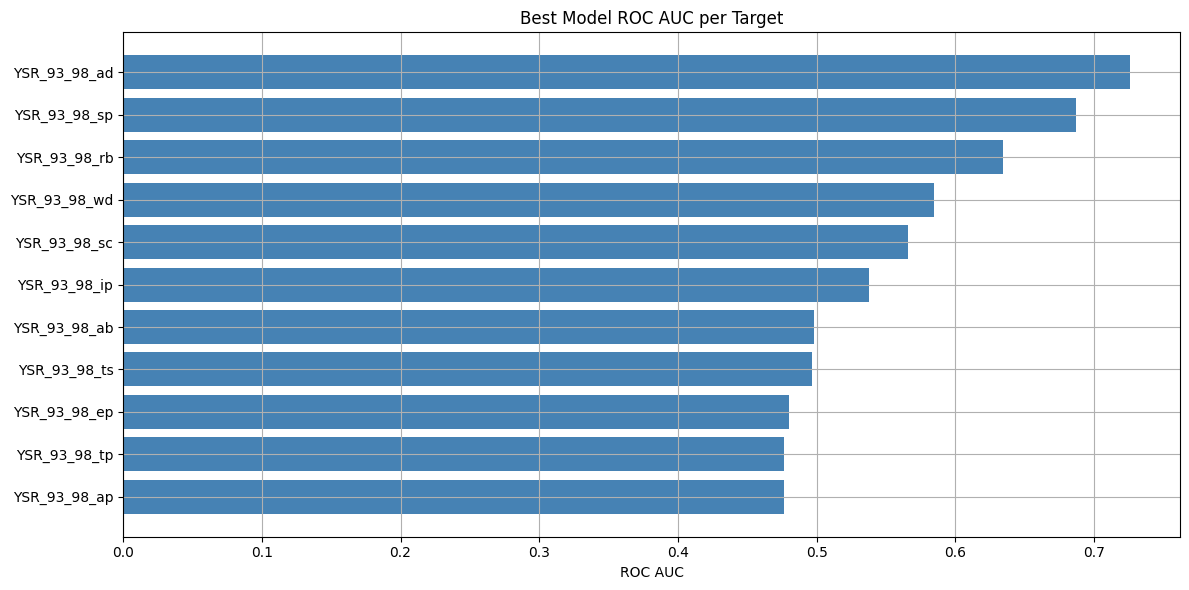

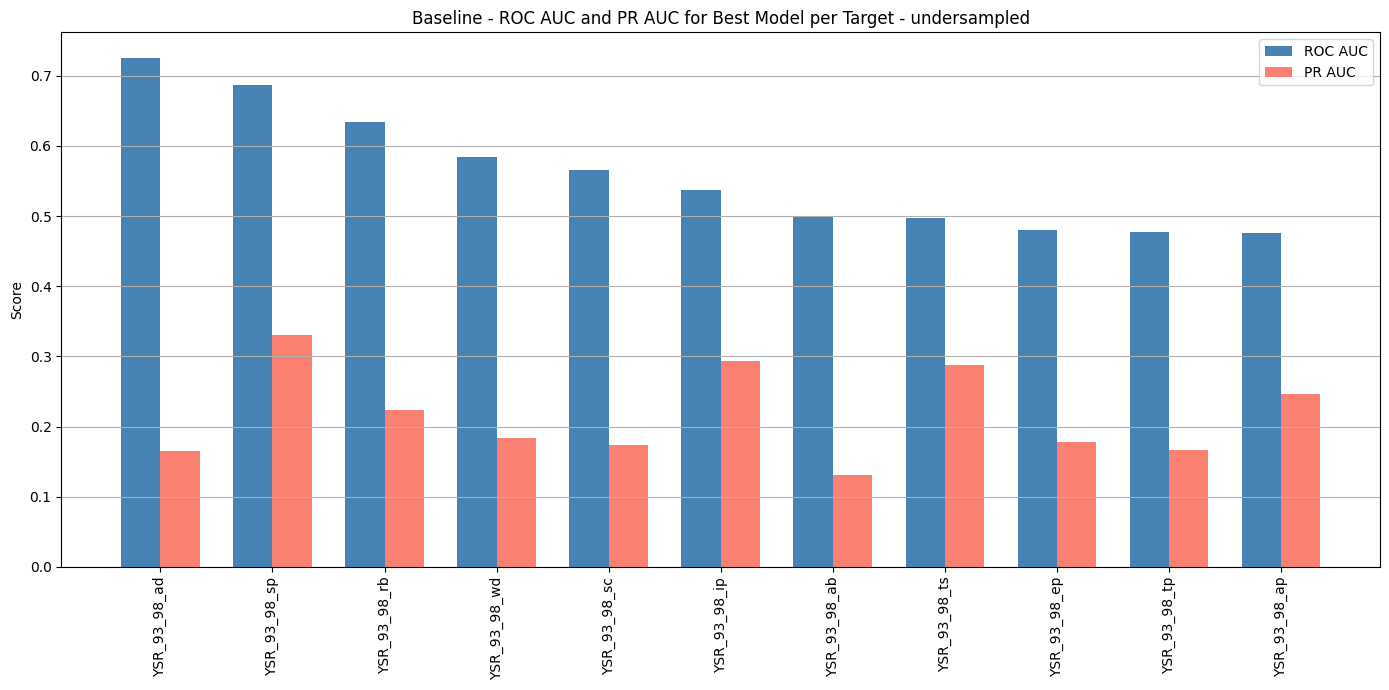

In [35]:
import pandas as pd

df_results = pd.read_csv("logistic_regression_metrics_all_targets_UNDERSAMPLING.csv")
df_valid = df_results.dropna(subset=["PR AUC", "F1"])

best_models = (
    df_valid
    .sort_values(by=["Target", "PR AUC", "F1"], ascending=[True, False, False])
    .groupby("Target")
    .head(1)
    .reset_index(drop=True)
)
import matplotlib.pyplot as plt

# Sort for better visualization
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

plt.figure(figsize=(12, 6))
plt.barh(best_models_sorted["Target"], best_models_sorted["ROC AUC"], color='steelblue')
plt.xlabel("ROC AUC")
plt.title("Best Model ROC AUC per Target")
plt.gca().invert_yaxis()
plt.grid(True)
plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Sort by ROC AUC for cleaner plotting
best_models_sorted = best_models.sort_values(by="ROC AUC", ascending=False)

targets = best_models_sorted["Target"]
x = np.arange(len(targets))

roc_auc = best_models_sorted["ROC AUC"]
pr_auc = best_models_sorted["PR AUC"]

width = 0.35  # width of bars

plt.figure(figsize=(14, 7))
plt.bar(x - width/2, roc_auc, width, label='ROC AUC', color='steelblue')
plt.bar(x + width/2, pr_auc, width, label='PR AUC', color='salmon')

plt.xticks(x, targets, rotation=90)
plt.ylabel("Score")
plt.title("Baseline - ROC AUC and PR AUC for Best Model per Target - undersampled")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Filter valid models
